# 3.2.2 Random walk and differencing

## 차분

### 필요한 패키지 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import pmdarima as pm

### 필요한 함수 정의

In [2]:
def log_series(series):
    tmp = np.log(series)
    return pd.Series(tmp, series.index)

def diff_series(series, periods=1):
    return series.diff(periods=periods)

def plot_series(series, x_label, y_label, title):
    plt.figure(figsize=(10, 6))
    plt.plot(series,  color='black')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

### 차분 및 시각화

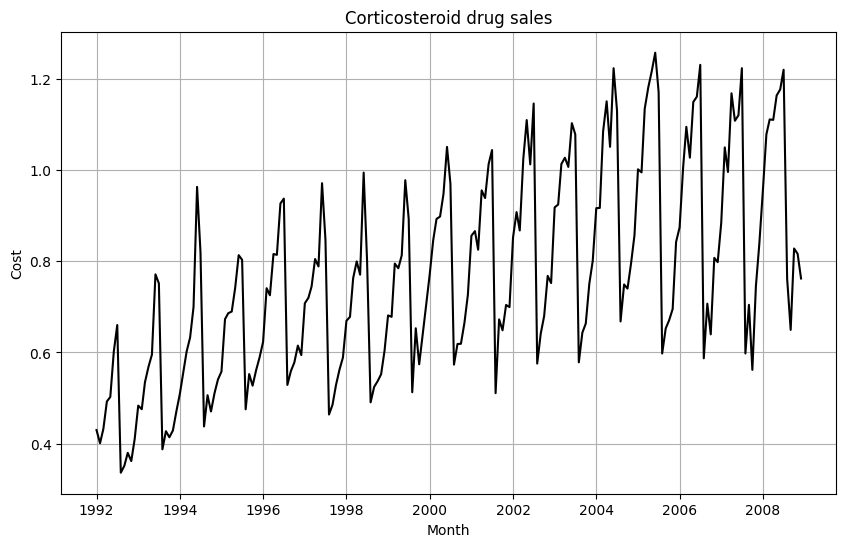

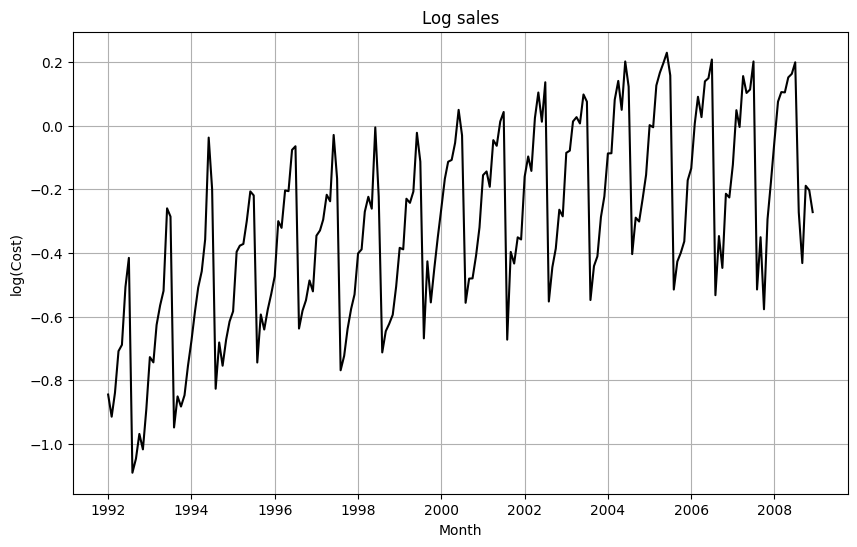

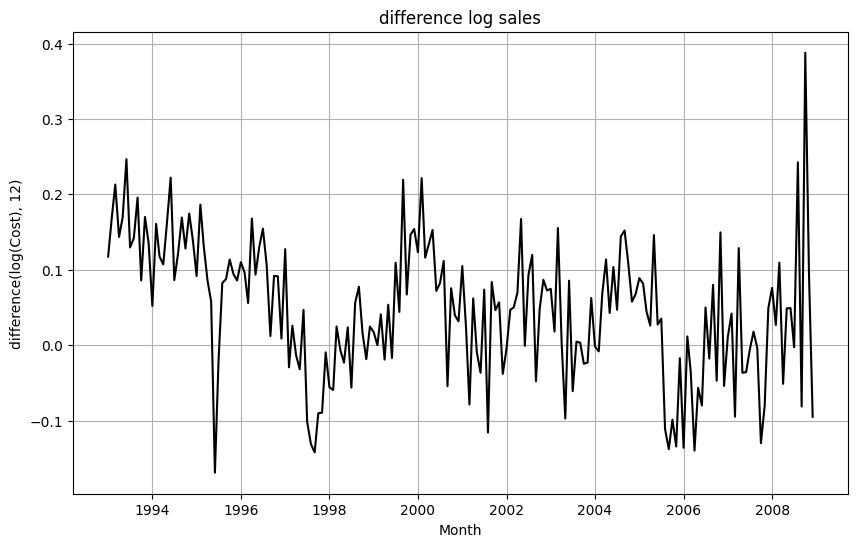

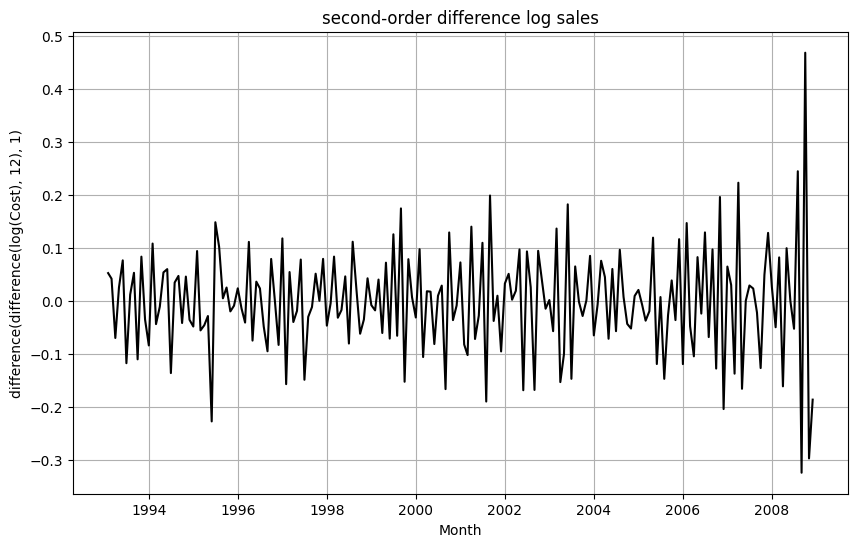

In [3]:
h02 = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/h02.csv")
h02 = pd.Series(list(h02.x), pd.date_range(start='1/1/1992', periods=h02.shape[0], freq='1MS'))
plot_series(h02, "Month", "Cost", "Corticosteroid drug sales")

log_h02 = log_series(h02)
plot_series(log_h02, "Month", "log(Cost)", "Log sales")

diff12_h02 = diff_series(log_h02, 12)
plot_series(diff12_h02, "Month", "difference(log(Cost), 12)", "difference log sales")

diff1_diff12_h02 = diff_series(diff12_h02)
plot_series(diff1_diff12_h02, "Month", "difference(difference(log(Cost), 12), 1)", "second-order difference log sales")

## 차분 자동 선택

In [4]:
def seasonal_strength(series):
    stl_result = STL(series).fit()
    r = stl_result.resid
    s = stl_result.seasonal
    var1 = r.var()
    var2 = (s+r).var()
    return max(0, 1-var1/var2)

seasonal_strength(log_h02)

0.9708953840295775

# 3.2.3 AR

## AR(1) 예시

### 시각화

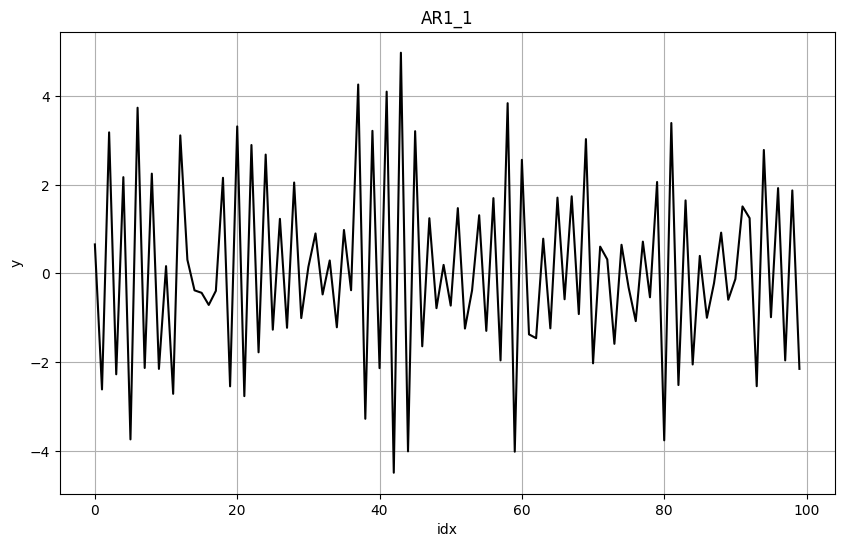

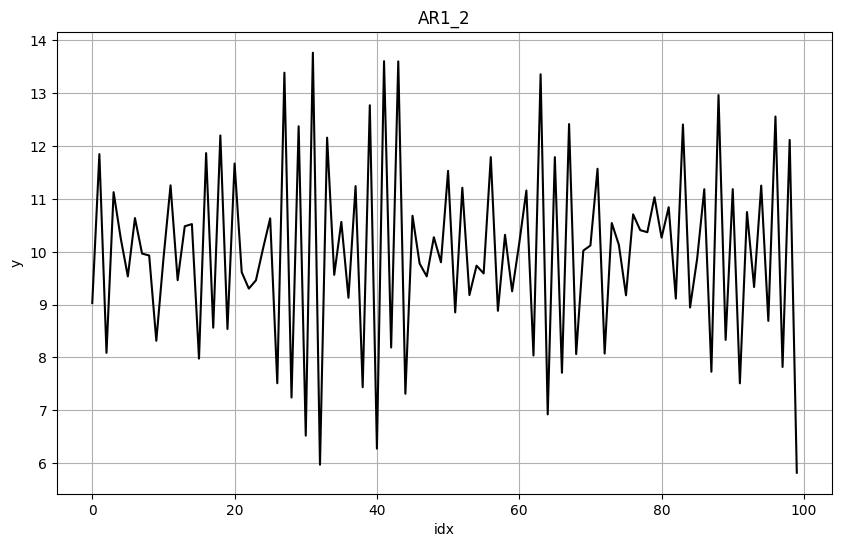

In [5]:
def AR1(c=0, phi=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c/(1 - phi) + noise[0]]
    for i in range(1, n):
        data.append(c + phi * data[i-1] + noise[i])
    return data

ex_AR1_1 = pd.Series(AR1(phi=-0.8))
plot_series(ex_AR1_1, "idx", "y", "AR1_1")

ex_AR1_2 = pd.Series(AR1(c=18, phi=-0.8))
plot_series(ex_AR1_2, "idx", "y", "AR1_2")

### ACF 시각화

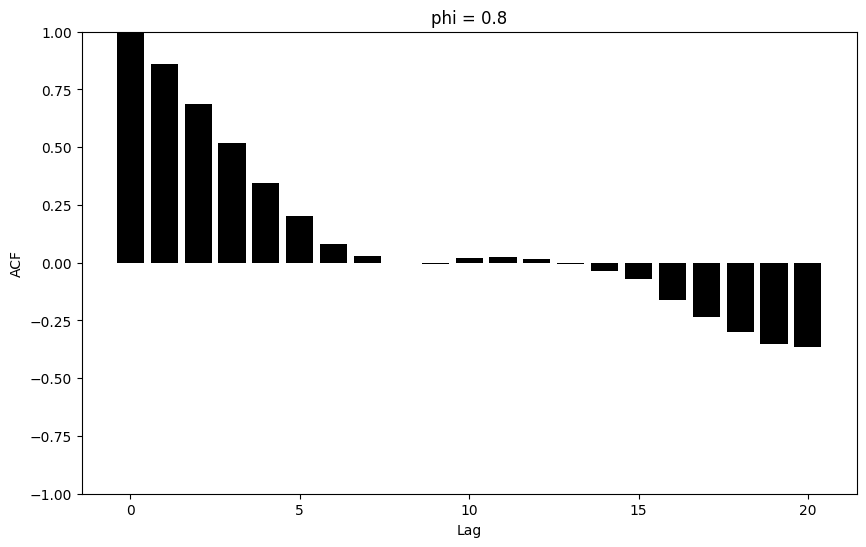

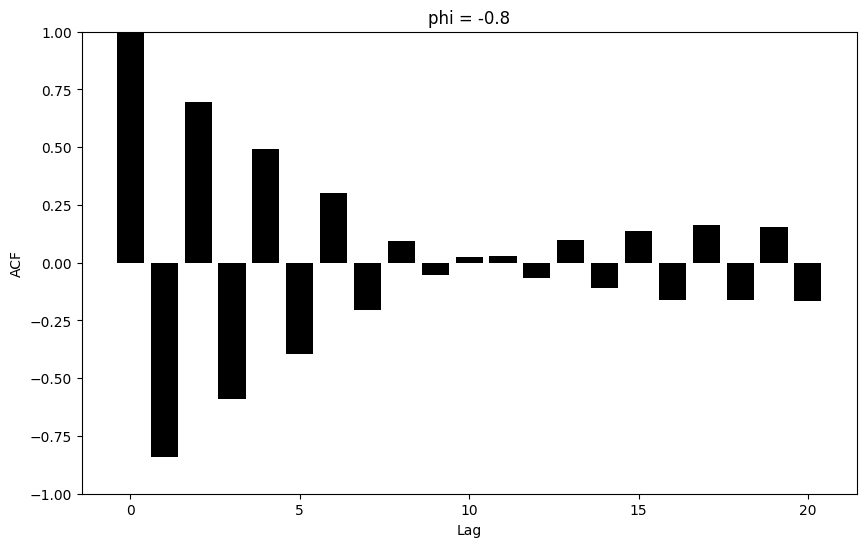

In [6]:
def show_ACF(series, title, start=0, nlags=None):
    plt.figure(figsize=(10, 6))
    ACF = acf(series, fft=False, nlags=nlags)
    plt.bar(range(start, ACF.shape[0]), ACF[start:], color='black')
    plt.xlabel("Lag")
    plt.ylabel("ACF")
    plt.ylim(-1, 1)
    plt.title(title)
    plt.show()

ex_AR1_3 = pd.Series(AR1(phi=0.8))
show_ACF(ex_AR1_3, "phi = 0.8")
show_ACF(ex_AR1_1, "phi = -0.8")

## 예시 2

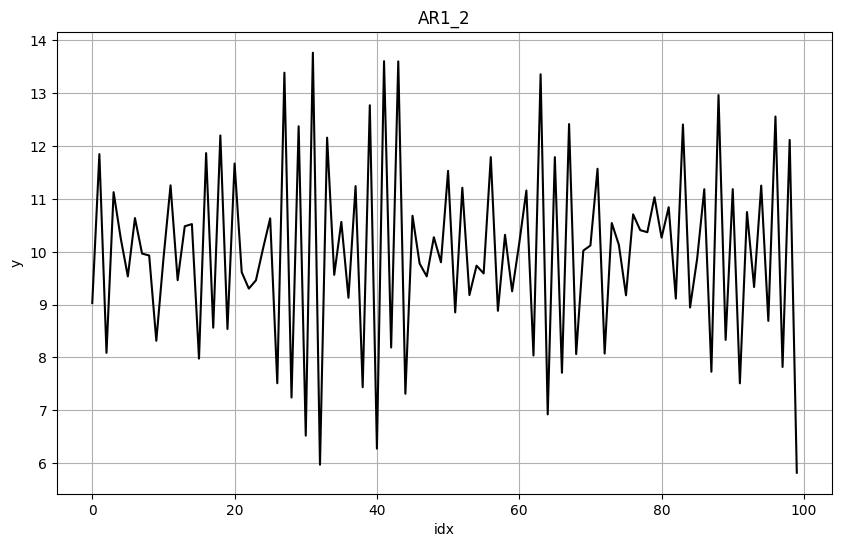

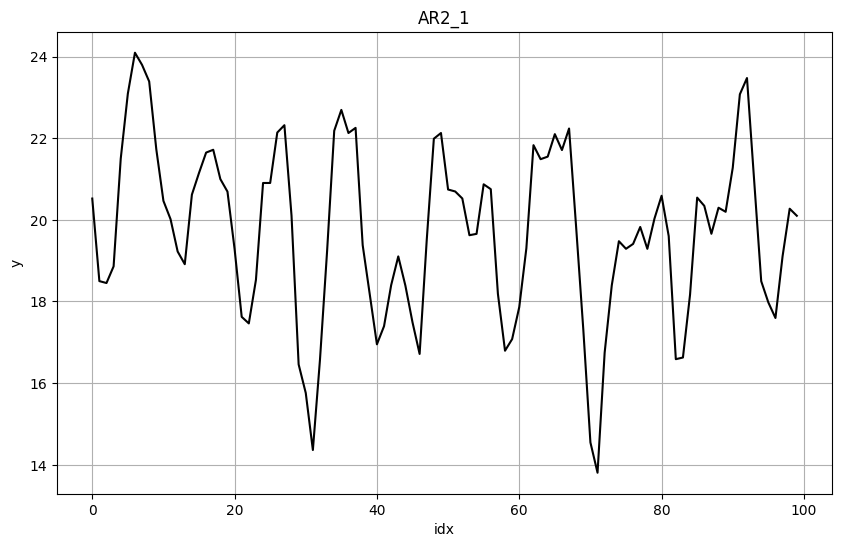

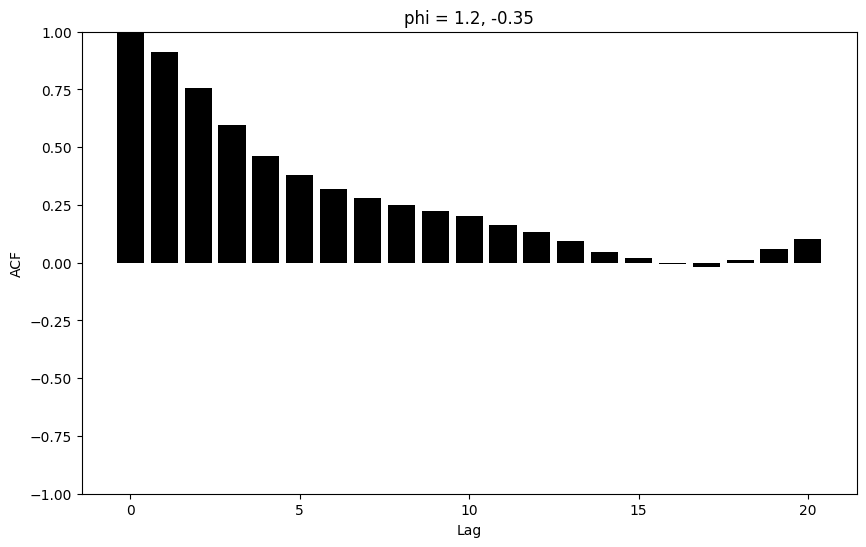

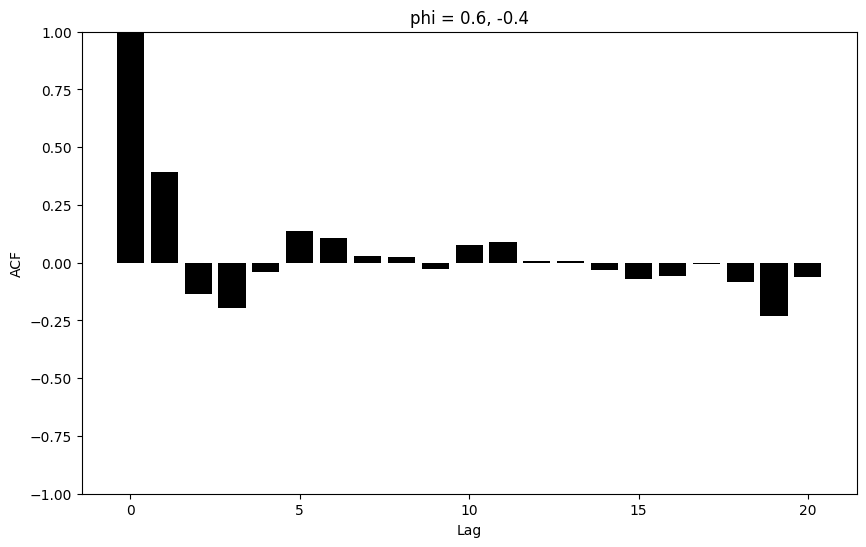

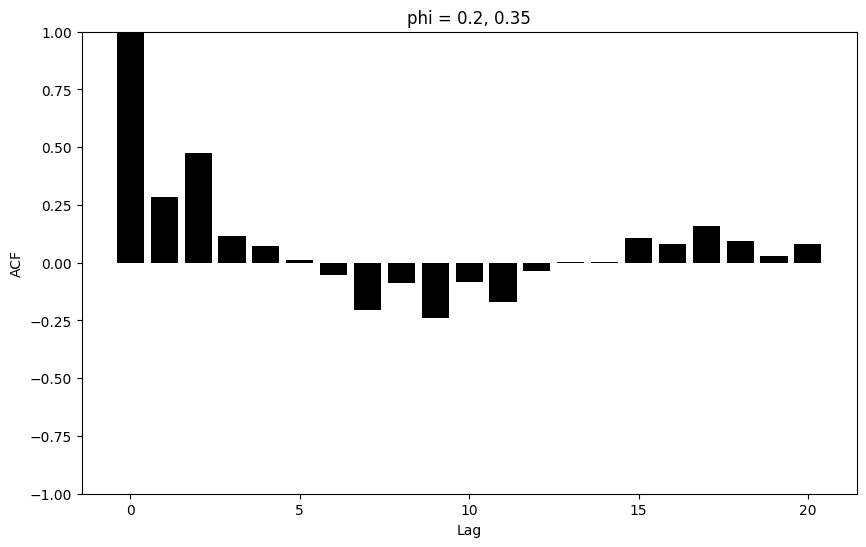

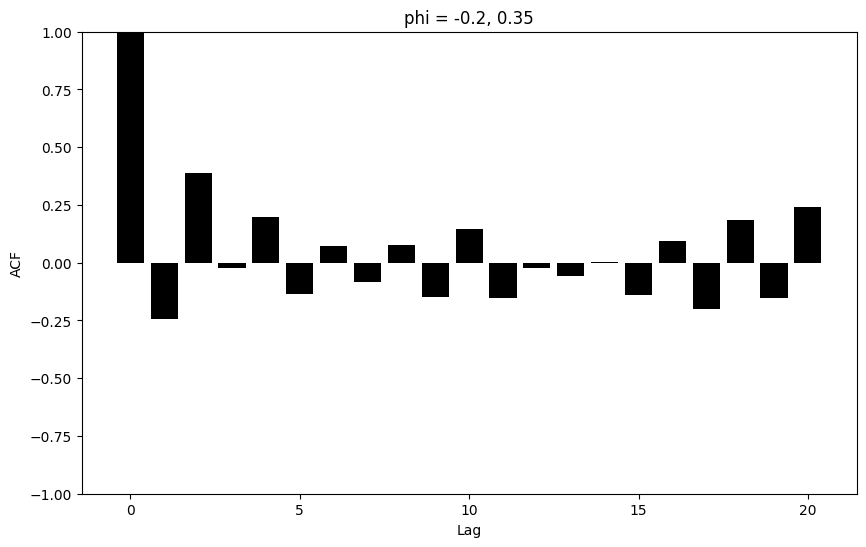

In [7]:
def AR2(c=0, phi1=0, phi2=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c/(1 - phi1 - phi2) + noise[0], c/(1 - phi1 - phi2) + noise[1]]
    for i in range(2, n):
        data.append(c + phi1 * data[i-1] + phi2 * data[i-2] + noise[i])
    return data

plot_series(ex_AR1_2, "idx", "y", "AR1_2")

ex_AR2_1 = pd.Series(AR2(c=8, phi1=1.3, phi2=-0.7))
plot_series(ex_AR2_1, "idx", "y", "AR2_1")

ex_AR2_2 = pd.Series(AR2(phi1=1.2, phi2=-0.35))
ex_AR2_3 = pd.Series(AR2(phi1=0.6, phi2=-0.4))
ex_AR2_4 = pd.Series(AR2(phi1=0.2, phi2=0.35))
ex_AR2_5 = pd.Series(AR2(phi1=-0.2, phi2=0.35))

show_ACF(ex_AR2_2, "phi = 1.2, -0.35")
show_ACF(ex_AR2_3, "phi = 0.6, -0.4")
show_ACF(ex_AR2_4, "phi = 0.2, 0.35")
show_ACF(ex_AR2_5, "phi = -0.2, 0.35")

## PACF

In [8]:
noise = np.random.normal(0, 1, 100)
data = [noise[0]]
for i in range(1, 100):
    data.append(0.4 * data[i-1] + noise[i])
ex_AR3_1 = pd.Series(data)

data = [noise[0]]
for i in range(1, 100):
    data.append(0.95 * data[i-1] + noise[i])
ex_AR3_2 = pd.Series(data)

### 시각화

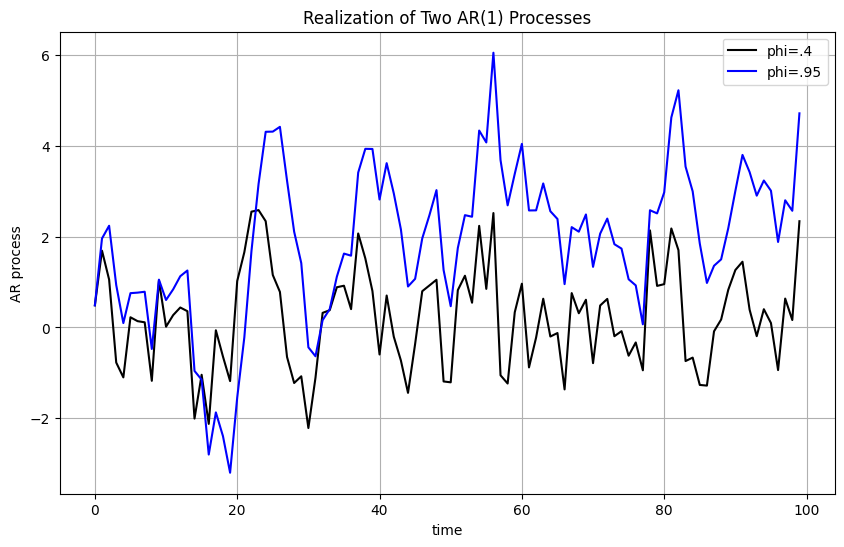

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(ex_AR3_1,  color='black', label='phi=.4')
plt.plot(ex_AR3_2,  color='b', label='phi=.95')
plt.xlabel("time")
plt.ylabel("AR process")
plt.title("Realization of Two AR(1) Processes")
plt.grid(True)
plt.legend()
plt.show()

### ACF 시각화

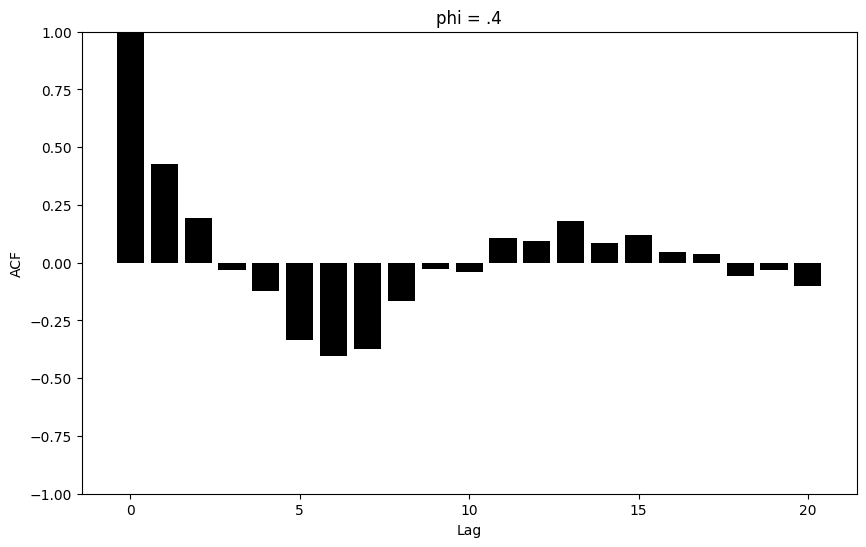

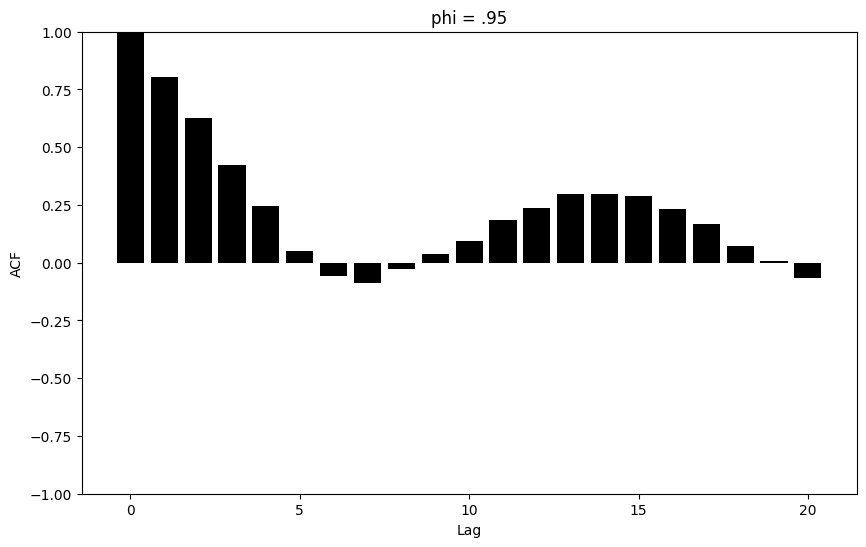

In [10]:
show_ACF(ex_AR3_1, "phi = .4")
show_ACF(ex_AR3_2, "phi = .95")

### PACF 시각화

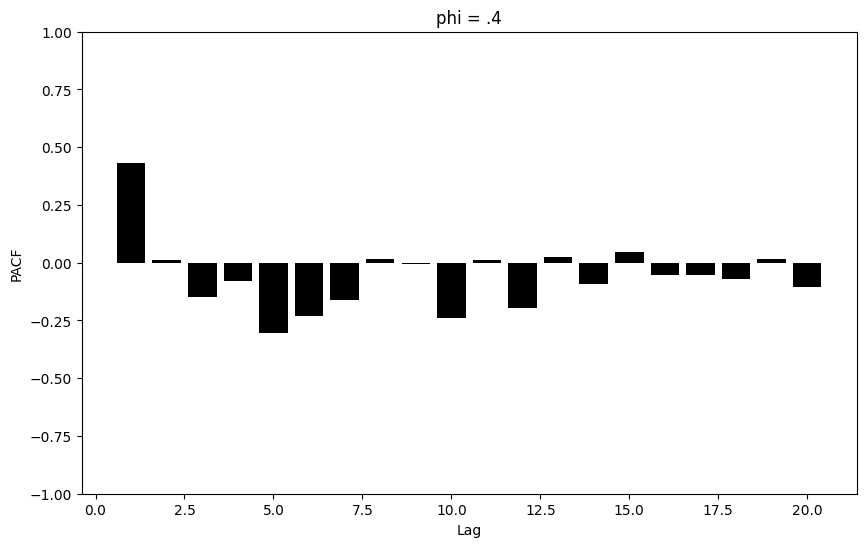

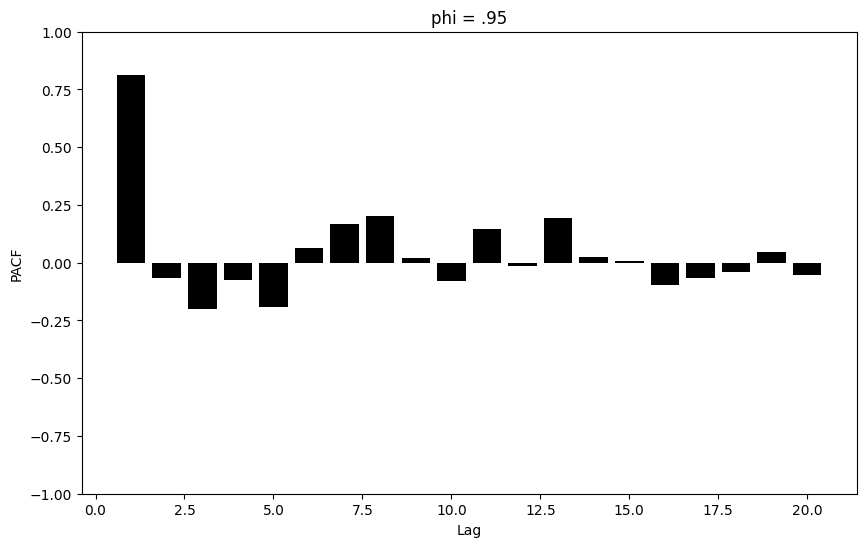

In [11]:
def show_PACF(series, title, start=1, nlags=None):
    plt.figure(figsize=(10, 6))
    PACF = pacf(series, nlags=nlags)
    plt.bar(range(start, PACF.shape[0]), PACF[start:], color='black')
    plt.xlabel("Lag")
    plt.ylabel("PACF")
    plt.ylim(-1, 1)
    plt.title(title)
    plt.show()
    
show_PACF(ex_AR3_1, "phi = .4")
show_PACF(ex_AR3_2, "phi = .95")

# 3.2.4 MA 

## 예시

### 시각화

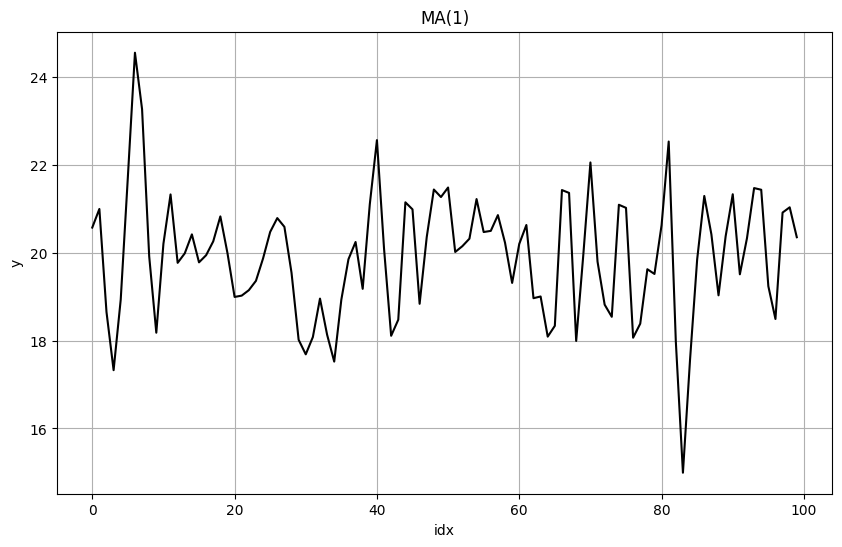

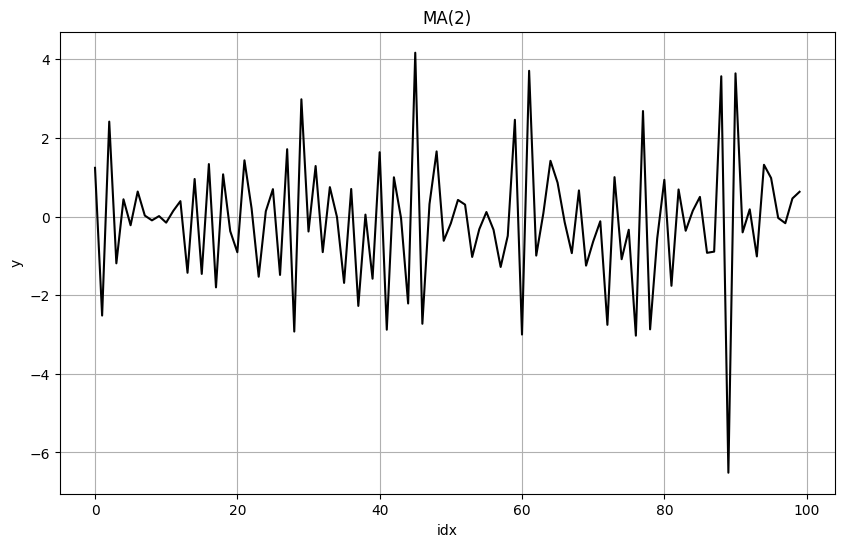

In [12]:
def MA1(c=0, theta=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c + noise[0]]
    for i in range(1, n):
        data.append(c + noise[i] + theta * noise[i-1])
    return data

def MA2(c=0, theta1=0, theta2=0, noise=1, n=100):
    noise = np.random.normal(0, noise, n)
    data = [c + noise[0], c + theta1 * noise[0] + noise[1]]
    for i in range(2, n):
        data.append(c + noise[i] + theta1 * noise[i-1] + theta2 * noise[i-2])
    return data

ex_MA1_1 = pd.Series(MA1(c=20, theta=0.8))
plot_series(ex_MA1_1, "idx", "y", "MA(1)")

ex_MA1_2 = pd.Series(MA2(theta1=-1, theta2=0.8))
plot_series(ex_MA1_2, "idx", "y", "MA(2)")

### 2차 시각화

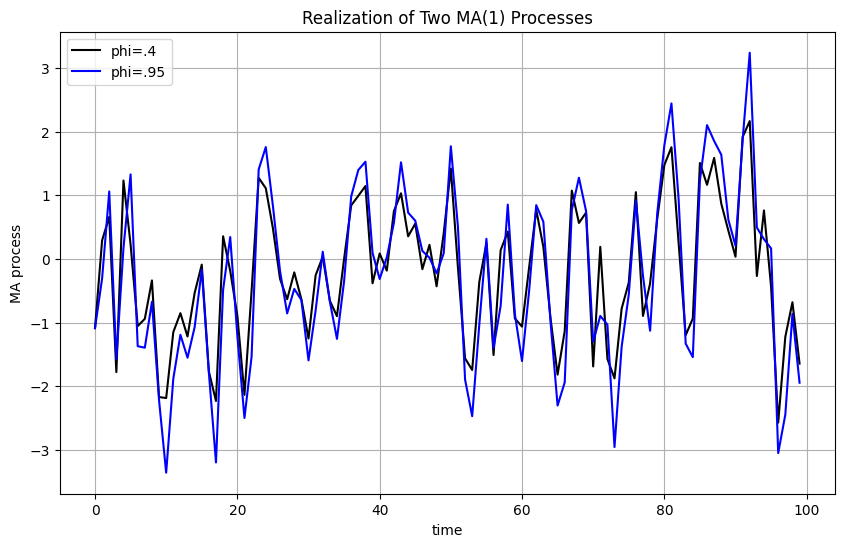

In [13]:
noise = np.random.normal(0, 1, 100)

data = [noise[0]]
for i in range(1, 100):
    data.append(noise[i] + 0.4 * noise[i-1])
ex_MA2_1 = pd.Series(data)

data = [noise[0]]
for i in range(1, 100):
    data.append(noise[i] + 0.95 * noise[i-1])
ex_MA2_2 = pd.Series(data)

plt.figure(figsize=(10, 6))
plt.plot(ex_MA2_1,  color='black', label='phi=.4')
plt.plot(ex_MA2_2,  color='b', label='phi=.95')
plt.xlabel("time")
plt.ylabel("MA process")
plt.title("Realization of Two MA(1) Processes")
plt.grid(True)
plt.legend()
plt.show()

### ACF 시각화

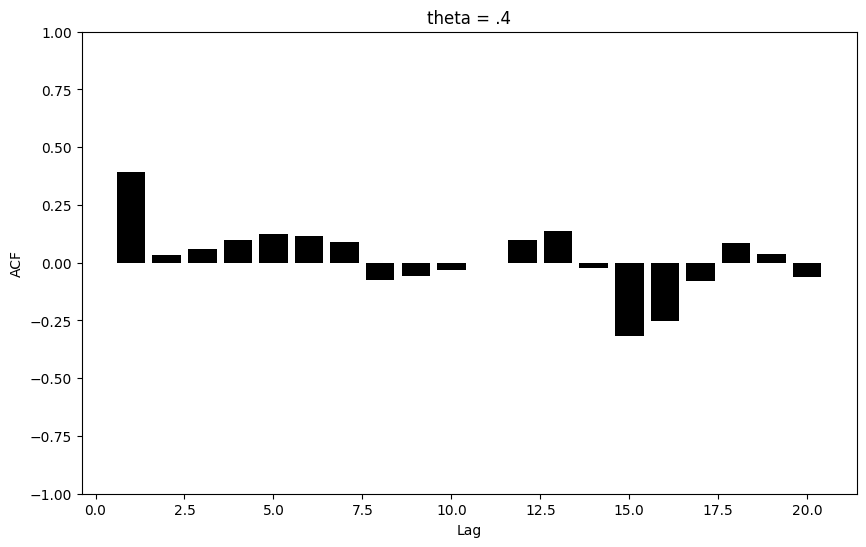

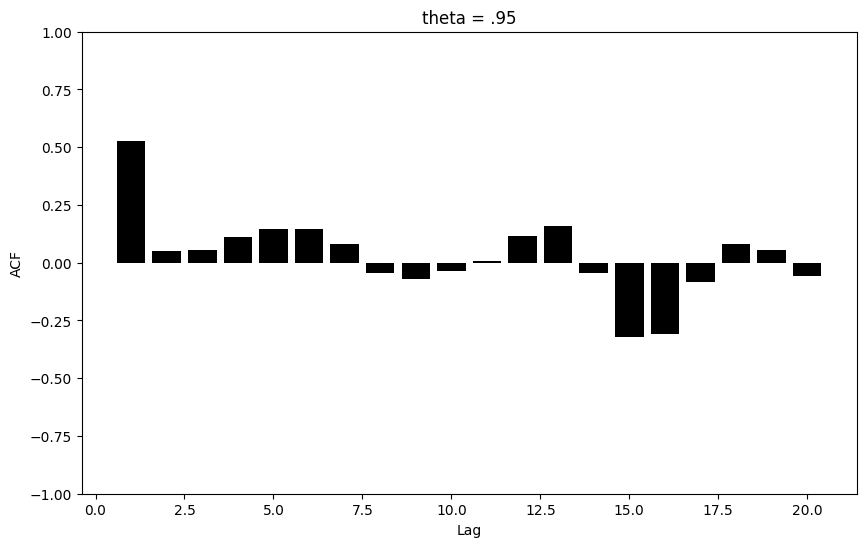

In [14]:
show_ACF(ex_MA2_1, "theta = .4", start=1)
show_ACF(ex_MA2_2, "theta = .95", start=1)

### PACF 시각화

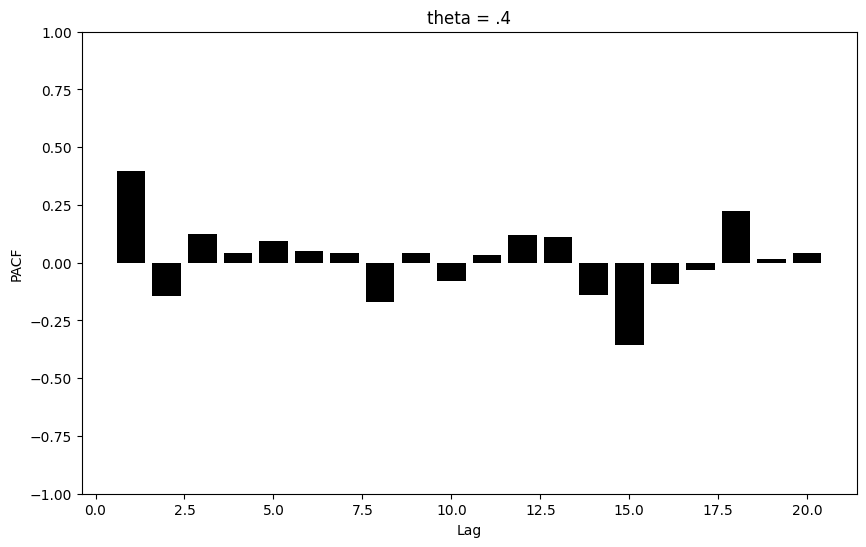

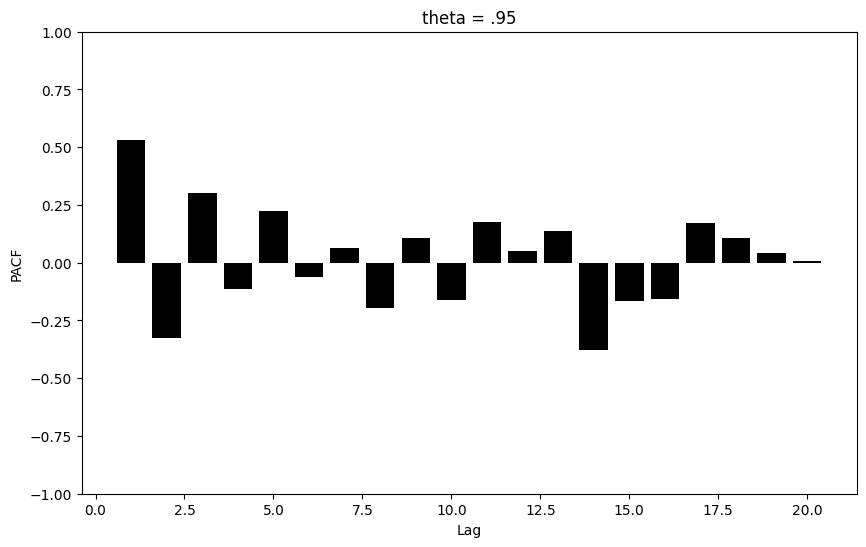

In [15]:
show_PACF(ex_MA2_1, "theta = .4")
show_PACF(ex_MA2_2, "theta = .95")

# 3.2.5 ARIMA

### 데이터 불러오기

In [16]:
global_economy = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.3/global_economy.csv')
global_economy['Year'] = pd.to_datetime(global_economy['Year'], format='%Y')
egypt_exports = global_economy[global_economy['Code'] == 'EGY']
egypt_series = pd.Series(list(egypt_exports['Exports']), egypt_exports['Year'])

### 시각화

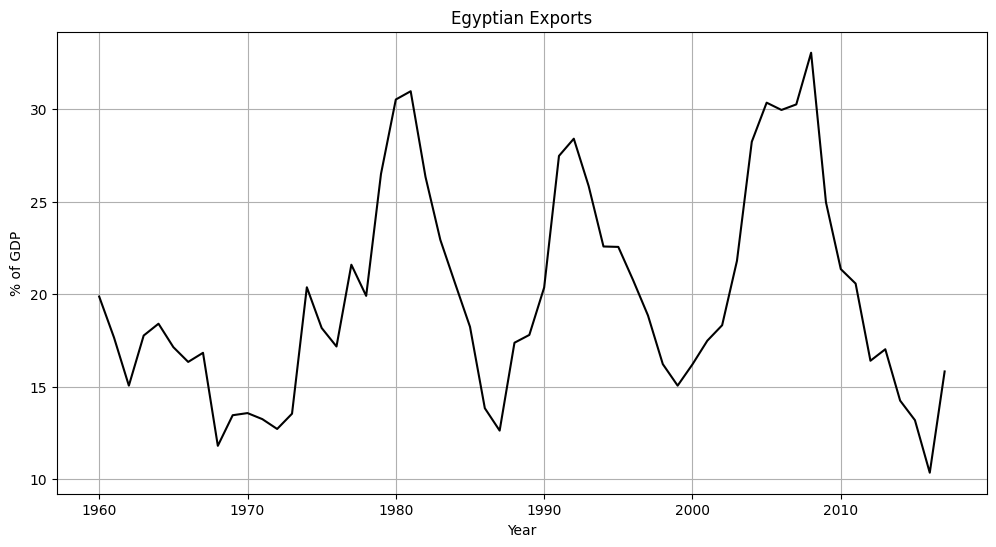

In [17]:
plt.figure(figsize=(12, 6))
plt.plot(egypt_series, color='black')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Egyptian Exports')
plt.grid(True)
plt.show()

### ACF 시각화

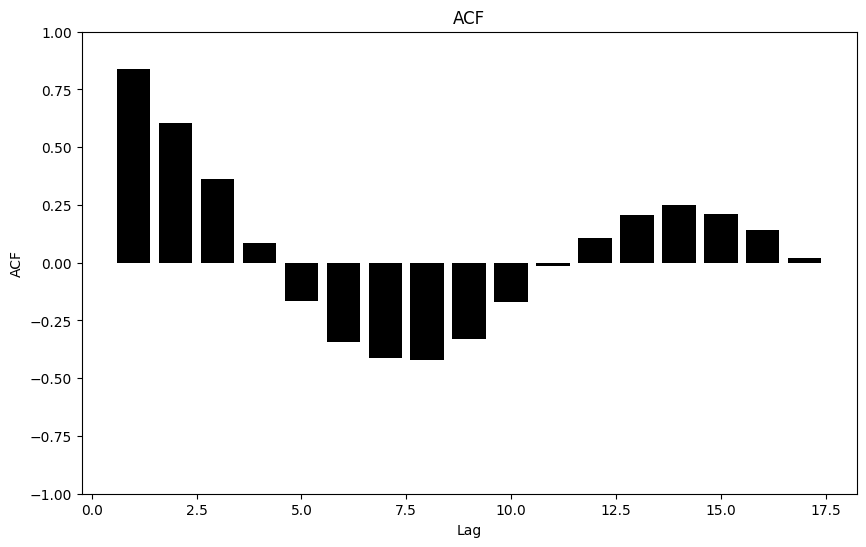

In [18]:
show_ACF(egypt_series, "ACF", 1)

### PACF 시각화

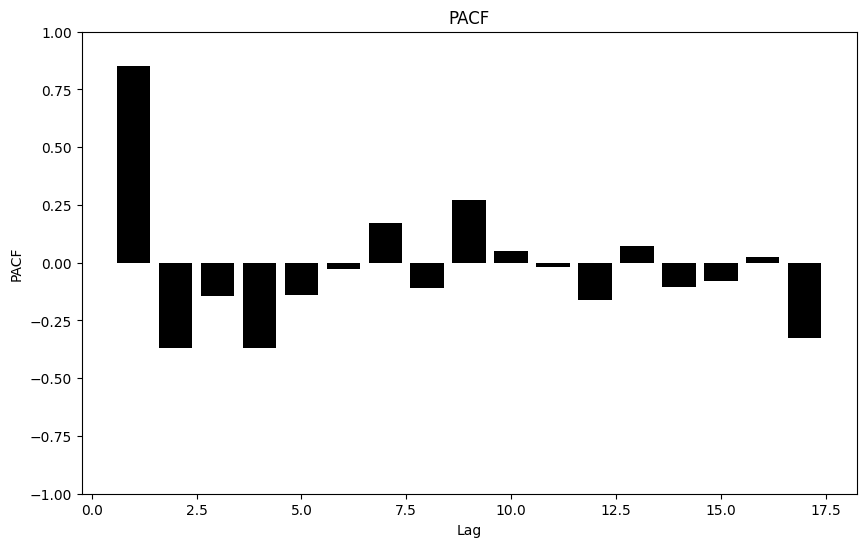

In [19]:
show_PACF(egypt_series, "PACF", 1)

### 모델 피팅

In [20]:
egypt_mod = ARIMA(egypt_series, order=(2,0,1))
egypt_res = egypt_mod.fit()
print(egypt_res.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -141.566
Date:                Fri, 07 Jun 2024   AIC                            293.132
Time:                        18:17:07   BIC                            303.434
Sample:                    01-01-1960   HQIC                           297.145
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1790      0.972     20.766      0.000      18.274      22.084
ar.L1          1.6764      0.127     13.239      0.000       1.428       1.925
ar.L2         -0.8034      0.102     -7.905      0.0

### 잔차 시각화

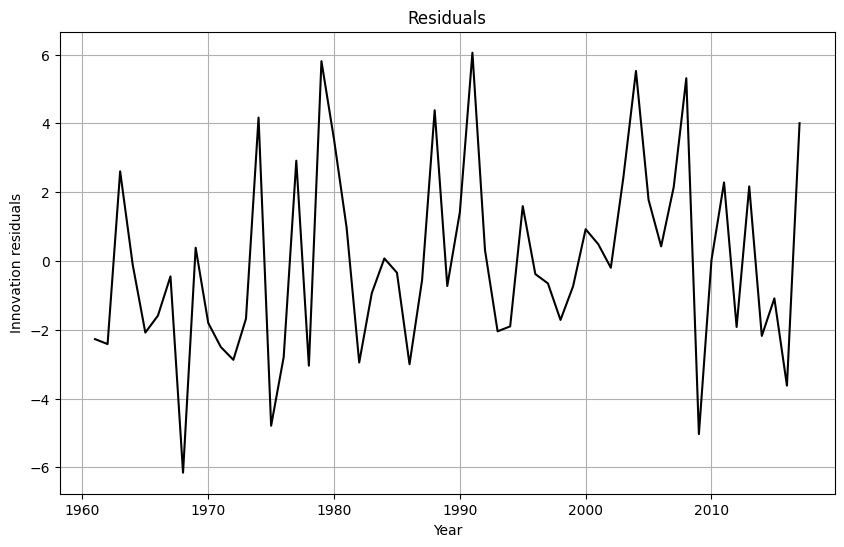

In [21]:
plot_series(egypt_res.resid[1:], "Year", "Innovation residuals", "Residuals")

### 잔차 ACF 시각화

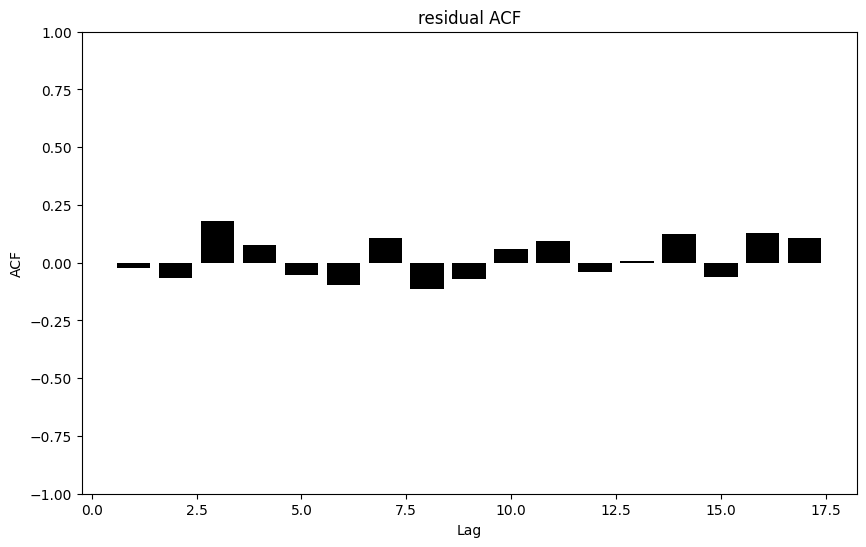

In [22]:
show_ACF(egypt_res.resid[1:], "residual ACF", 1)

### 잔차 히스토그램

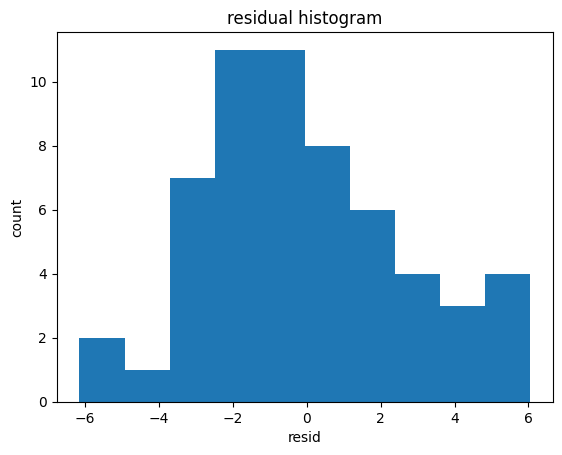

In [23]:
def hist_resid(res):
    plt.hist(res)
    plt.xlabel("resid")
    plt.ylabel("count")
    plt.title("residual histogram")
    plt.show()
    
hist_resid(egypt_res.resid[1:])

# 3.2.6 모델 선택

In [24]:
caf_exports = global_economy[global_economy['Code'] == 'CAF']
caf_series = pd.Series(list(caf_exports['Exports']), caf_exports['Year'])

### 시각화

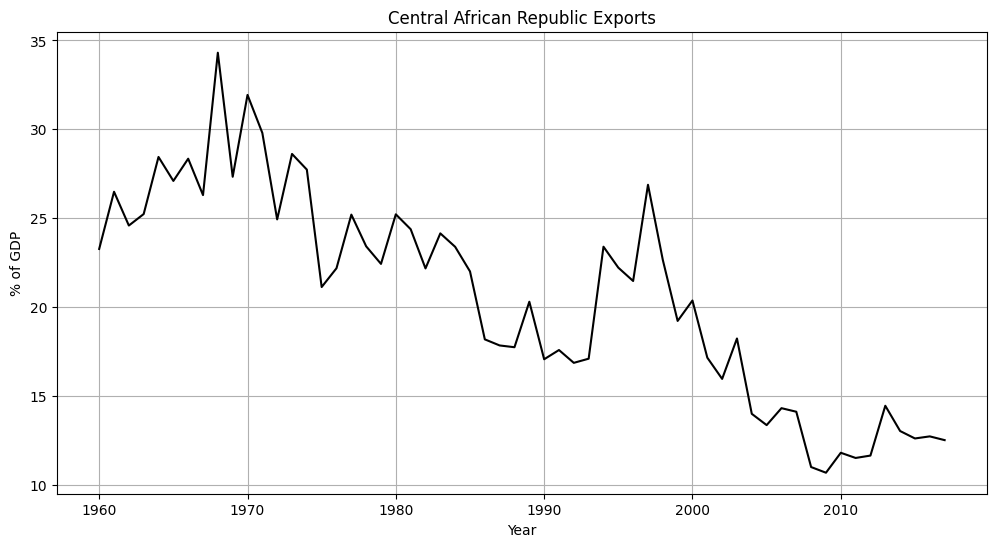

In [25]:
plt.figure(figsize=(12, 6))
plt.plot(caf_series, color='black')
plt.xlabel('Year')
plt.ylabel('% of GDP')
plt.title('Central African Republic Exports')
plt.grid(True)
plt.show()

### 차분 시각화

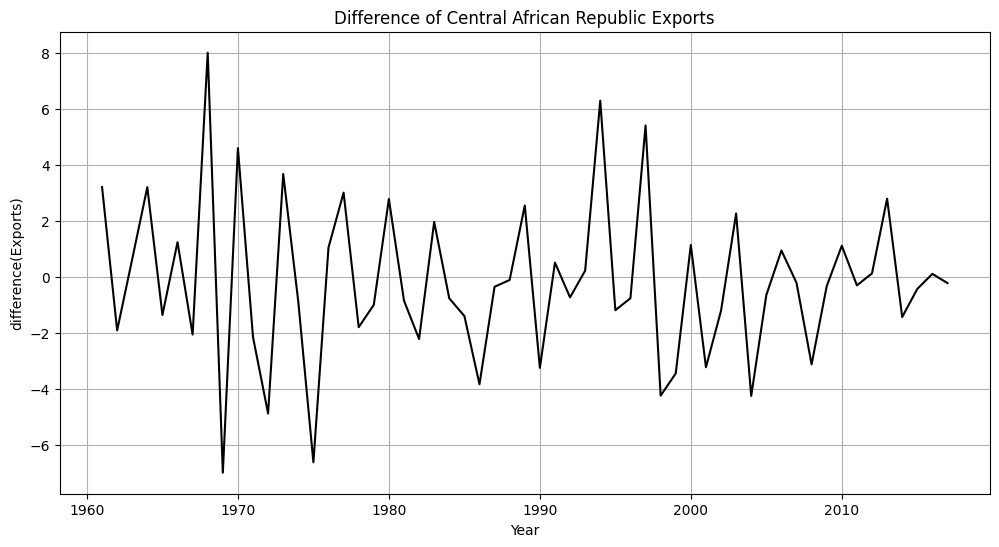

In [26]:
diff_caf_series = diff_series(caf_series)[1:]
plt.figure(figsize=(12, 6))
plt.plot(diff_caf_series, color='black')
plt.xlabel('Year')
plt.ylabel('difference(Exports)')
plt.title('Difference of Central African Republic Exports')
plt.grid(True)
plt.show()

### ACF 시각화

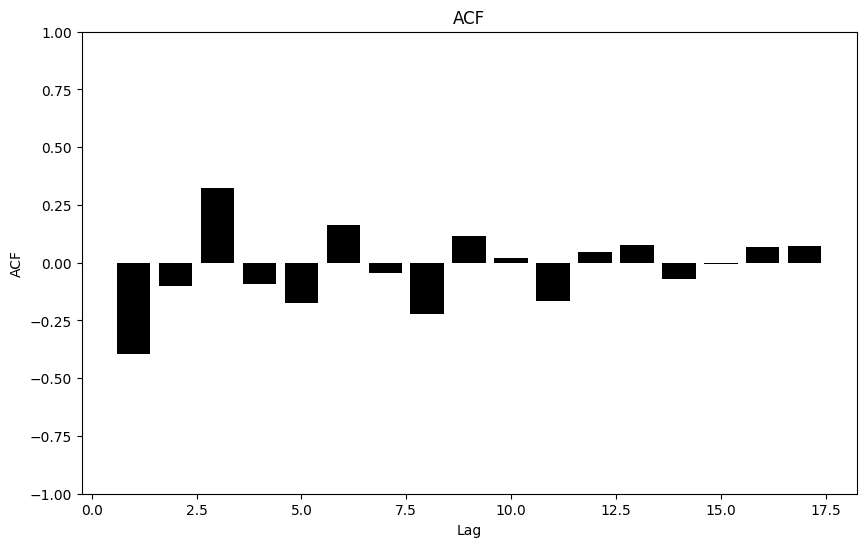

In [27]:
show_ACF(diff_caf_series, "ACF", 1)

### PACF 시각화

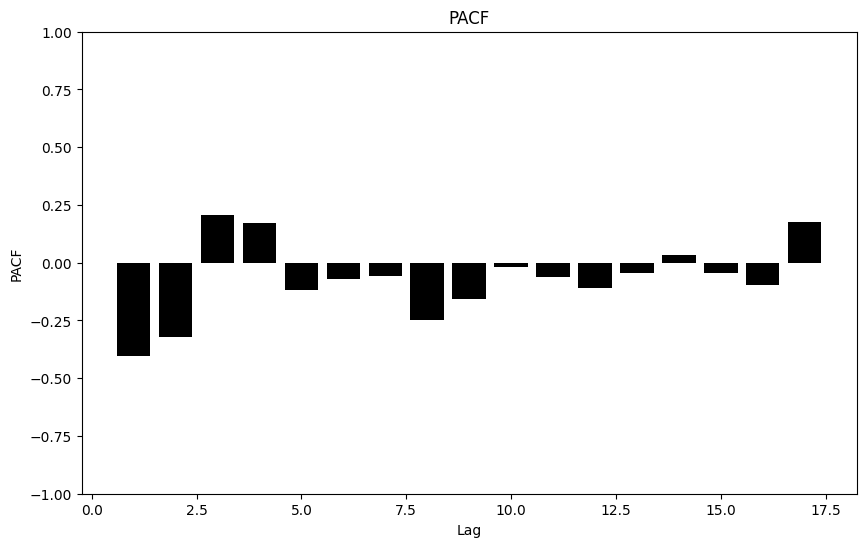

In [28]:
show_PACF(diff_caf_series, "PACF", 1)

### ARIMA 피팅

In [29]:
caf_arima_mod = pm.auto_arima(caf_series, start_p=3, d=1, start_q=0, seasonal=False, information_criterion="aicc", m=1)
print(caf_arima_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   58
Model:               SARIMAX(3, 1, 0)   Log Likelihood                -133.002
Date:                Fri, 07 Jun 2024   AIC                            274.005
Time:                        18:17:09   BIC                            282.177
Sample:                    01-01-1960   HQIC                           277.181
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4419      0.140     -3.152      0.002      -0.717      -0.167
ar.L2         -0.1850      0.176     -1.051      0.293      -0.530       0.160
ar.L3          0.2055      0.135      1.527      0.1

### ARIMA 시각화

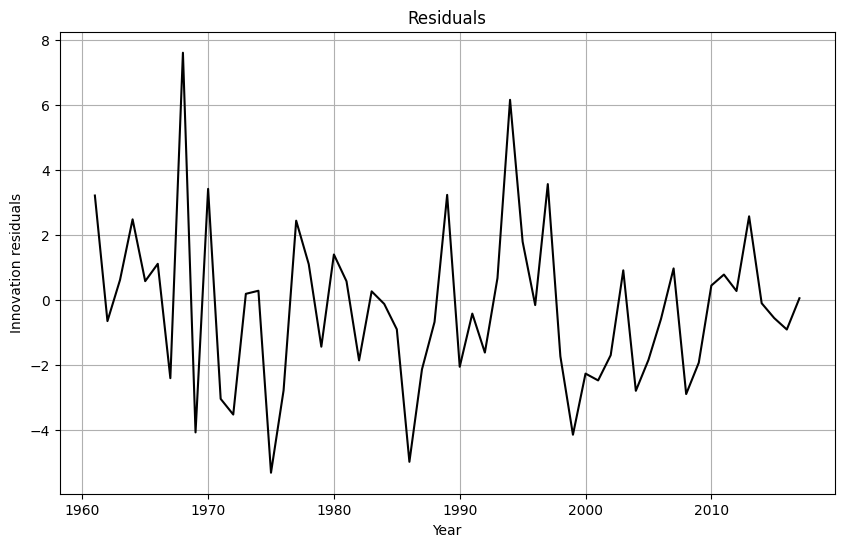

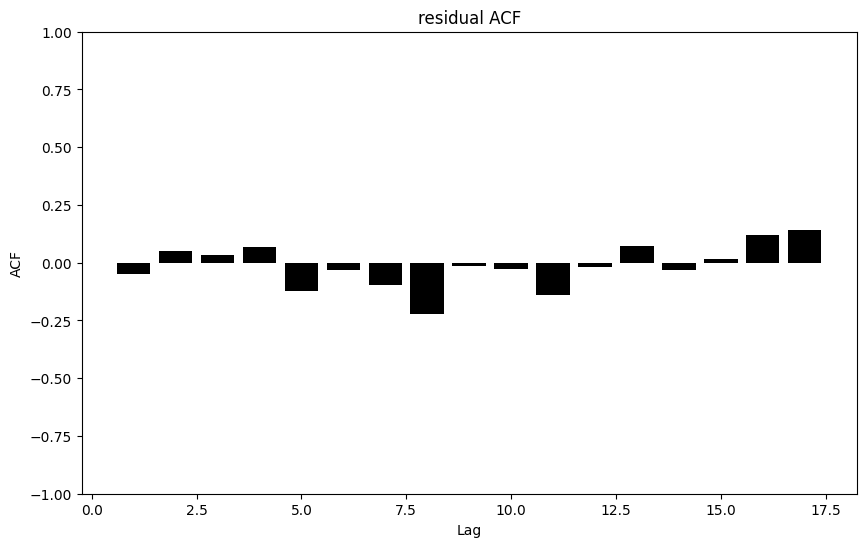

In [30]:
plot_series(caf_arima_mod.resid()[1:], "Year", "Innovation residuals", "Residuals")
show_ACF(caf_arima_mod.resid()[1:], "residual ACF", 1)

# 3.2.7 계절성 ARIMA

## 예시

### 데이터 불러오기

In [31]:
us_emp = pd.read_csv("https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.2/us_employment.csv")

### 데이터 전처리

In [32]:
us_emp['Month'] = pd.to_datetime(us_emp['Month'], format='%Y %m')
us_leis = us_emp[us_emp['Title'] == 'Leisure and Hospitality']
us_leis = us_leis[us_leis['Month'] >= '1/1/2000']
us_series = pd.Series(list(us_leis['Employed']), us_leis['Month'])

### 시각화

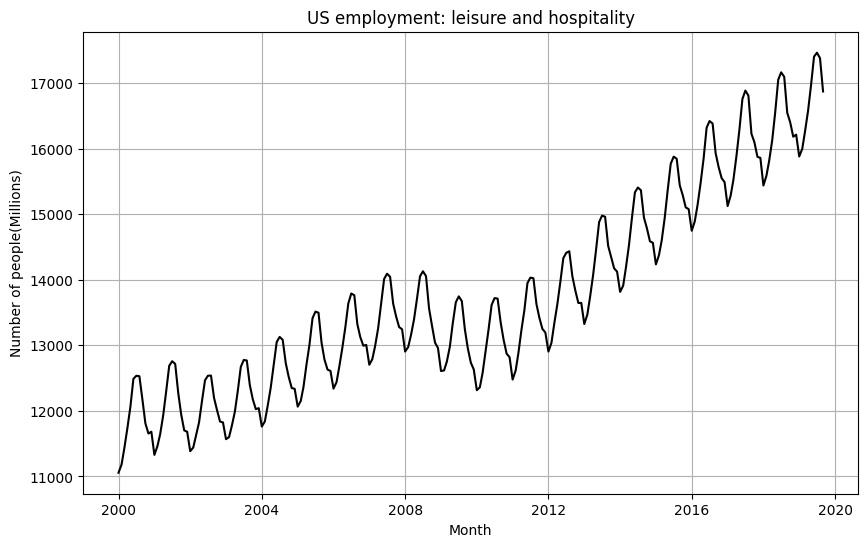

In [33]:
plot_series(us_series, "Month", "Number of people(Millions)", "US employment: leisure and hospitality")

### 계절 차분

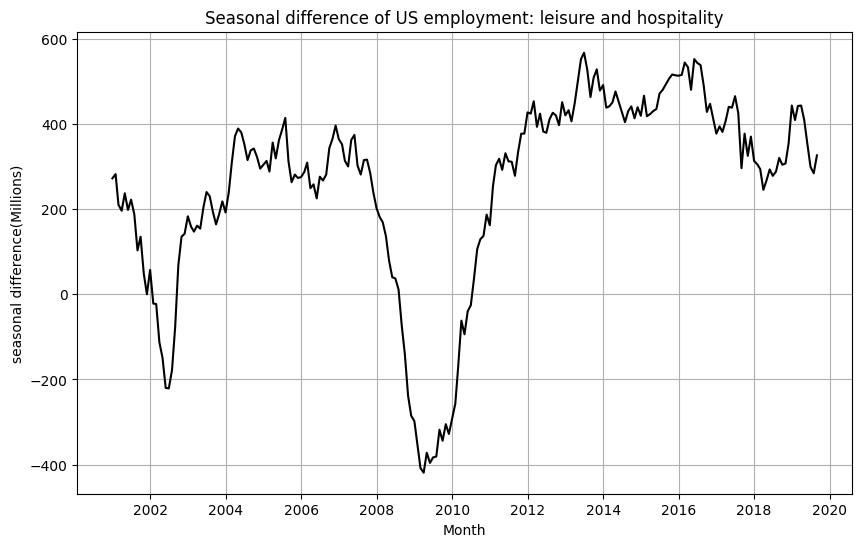

In [34]:
seasonaldiff_us_series = diff_series(us_series, 12)[12:]
plot_series(seasonaldiff_us_series, "Month", "seasonal difference(Millions)", "Seasonal difference of US employment: leisure and hospitality")

### ACF 및 PACF 시각화

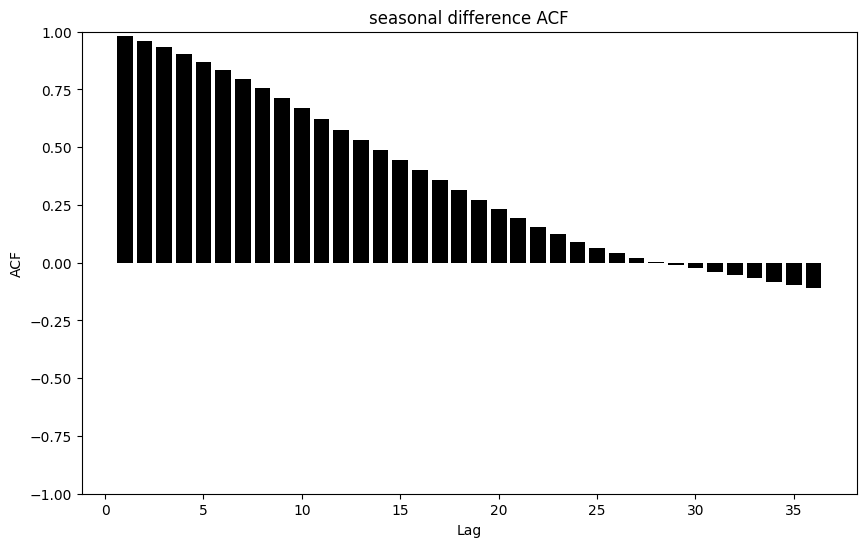

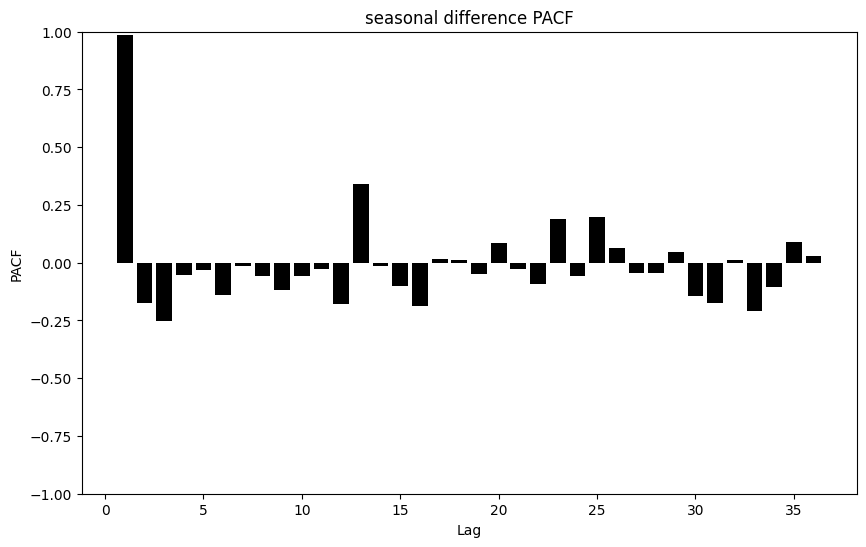

In [35]:
show_ACF(seasonaldiff_us_series, "seasonal difference ACF", start=1, nlags=36)
show_PACF(seasonaldiff_us_series, "seasonal difference PACF", start=1, nlags=36)

### 2차 차분

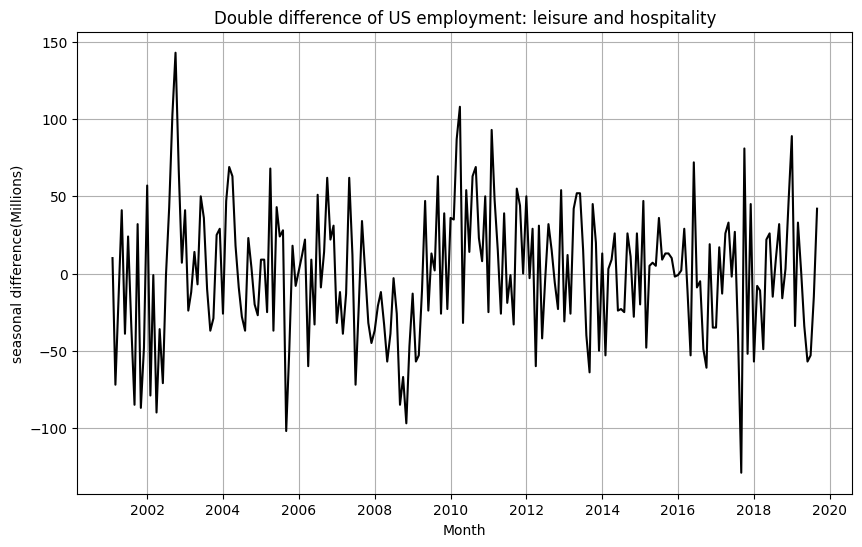

In [36]:
doubdiff_us_series = diff_series(seasonaldiff_us_series, 1)[1:]
plot_series(doubdiff_us_series, "Month", "seasonal difference(Millions)", "Double difference of US employment: leisure and hospitality")

### ACF 및 PACF 시각화

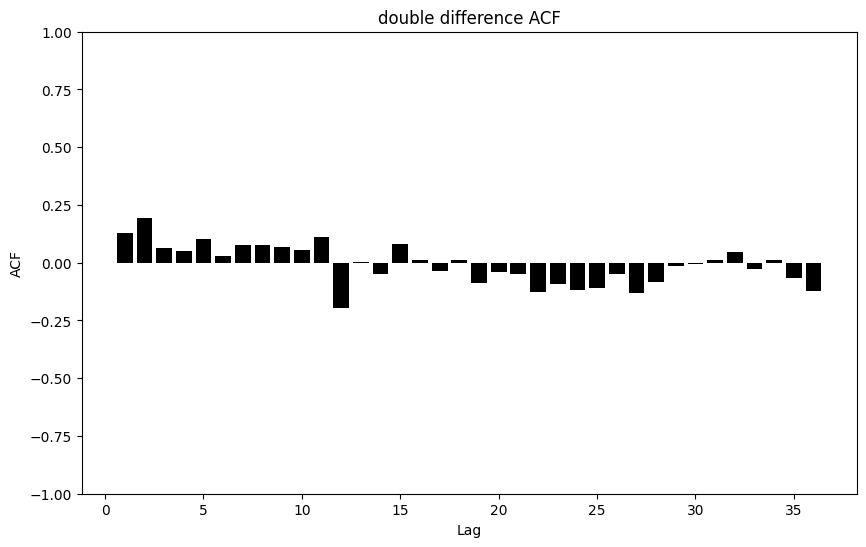

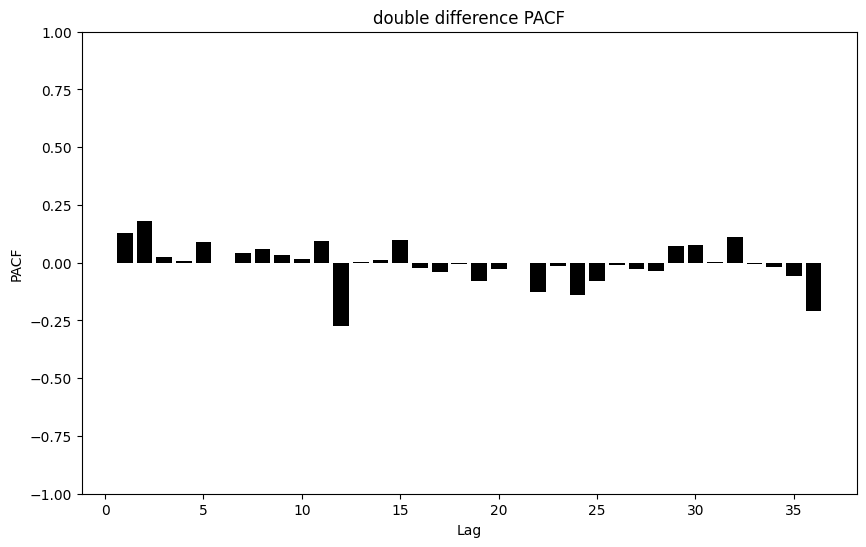

In [37]:
show_ACF(doubdiff_us_series, "double difference ACF", start=1, nlags=36)
show_PACF(doubdiff_us_series, "double difference PACF", start=1, nlags=36)

### ARIMA 모델 피팅

In [38]:
us_arima_mod = pm.auto_arima(us_series, start_p=2, d=1, start_q=0, start_P=1, D=1, start_Q=1, information_criterion="aicc", m=12)
print(us_arima_mod.summary())
us_arima = ARIMA(us_series, order=(1,1,1), seasonal_order=(0,1,1,12))
us_fit = us_arima.fit()
print(us_fit.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  237
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2], 12)   Log Likelihood               -1135.376
Date:                                 Fri, 07 Jun 2024   AIC                           2280.751
Time:                                         18:17:28   BIC                           2297.809
Sample:                                     01-01-2000   HQIC                          2287.637
                                          - 09-01-2019                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9055      0.070     12.988      0.000       0.769       1

### 잔차 시각화

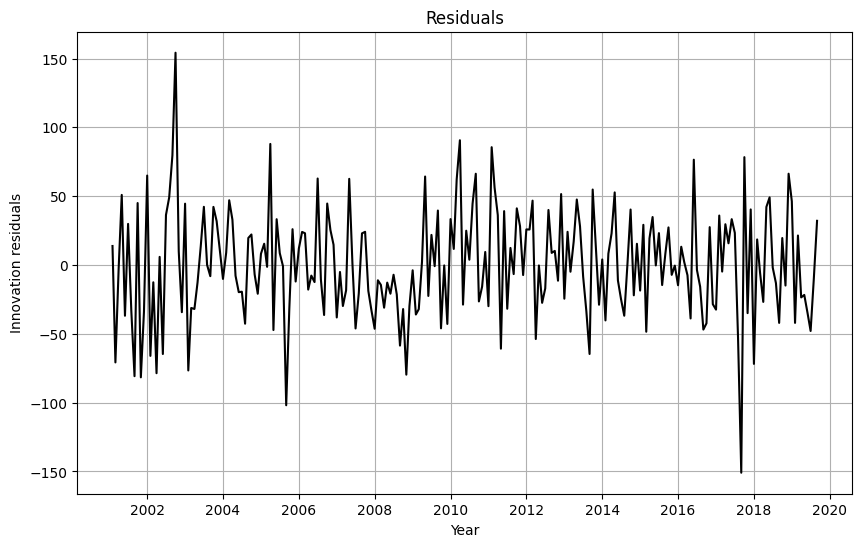

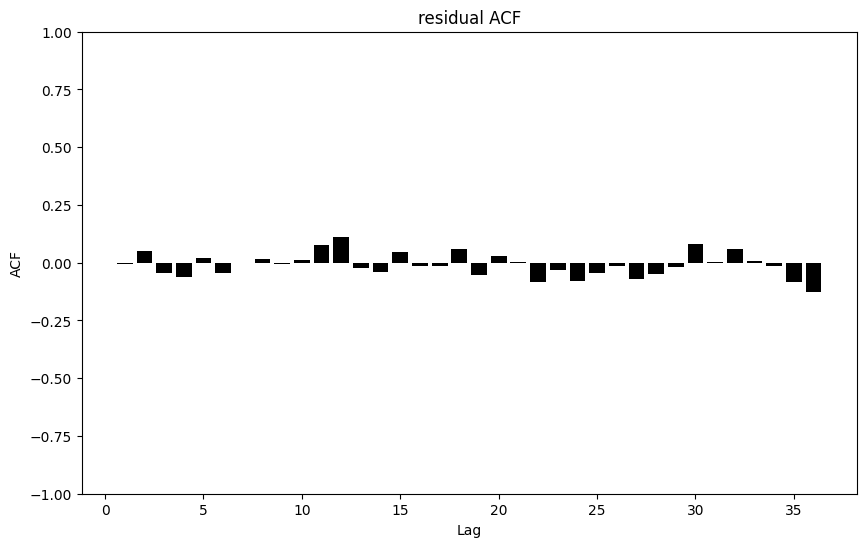

In [39]:
plot_series(us_fit.resid[13:], "Year", "Innovation residuals", "Residuals")
show_ACF(us_fit.resid[13:], "residual ACF", 1, nlags=36)

### 예측

In [40]:
forecast = us_fit.get_forecast(24).predicted_mean
ci = us_fit.get_forecast(24)
lower_ci80 = ci.conf_int(alpha=0.2).iloc[:,0]
upper_ci80 = ci.conf_int(alpha=0.2).iloc[:,1]
lower_ci95 = ci.conf_int(alpha=0.05).iloc[:,0]
upper_ci95 = ci.conf_int(alpha=0.05).iloc[:,1]

### 예측 시각화

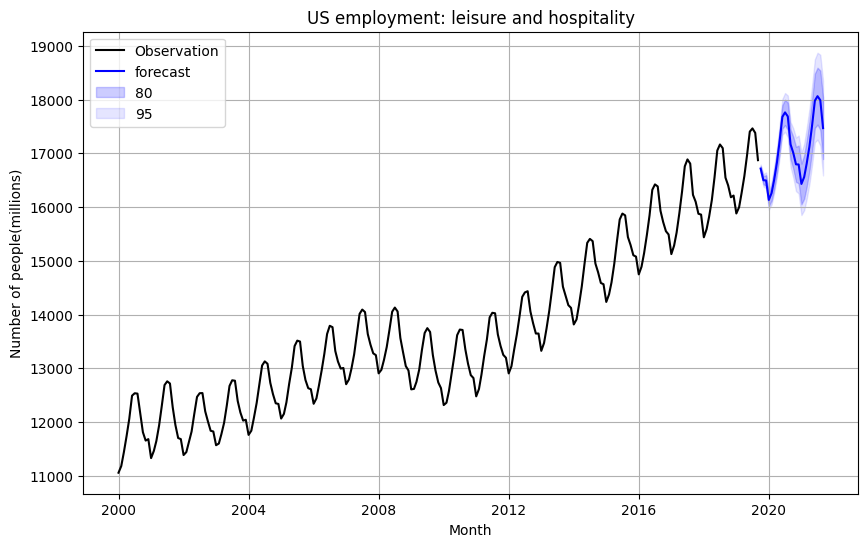

In [41]:
plt.figure(figsize=(10, 6))
plt.plot(us_series, label='Observation', color='black')
plt.plot(forecast, label='forecast', color='b')
plt.fill_between(forecast.index, lower_ci80, upper_ci80, label='80', color='b', alpha=.2)
plt.fill_between(forecast.index, lower_ci95, upper_ci95, label='95', color='b', alpha=.1)
plt.xlabel('Month')
plt.ylabel('Number of people(millions)')
plt.title("US employment: leisure and hospitality")
plt.grid(True)
plt.legend()
plt.show()

## 예시

### 시각화

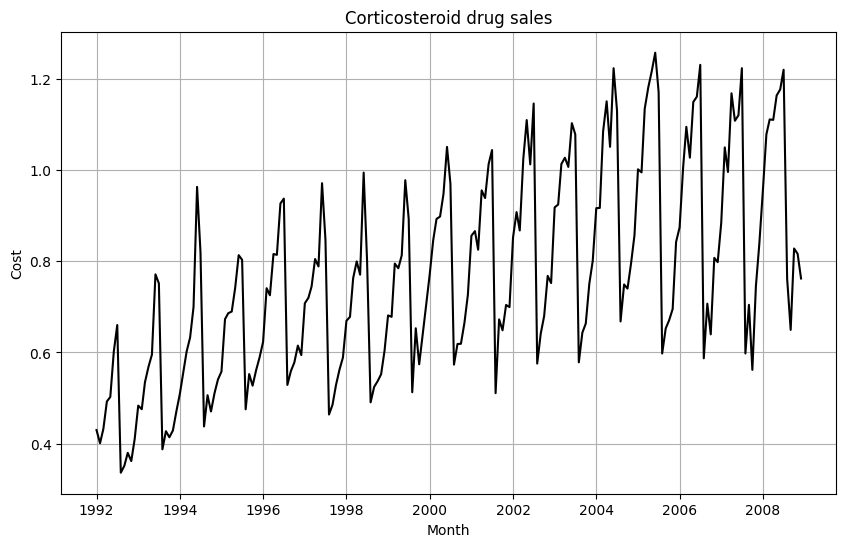

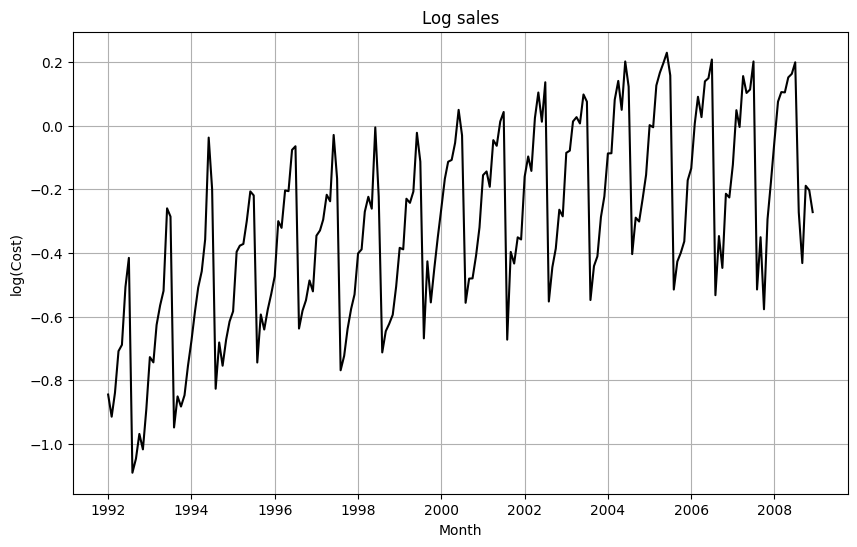

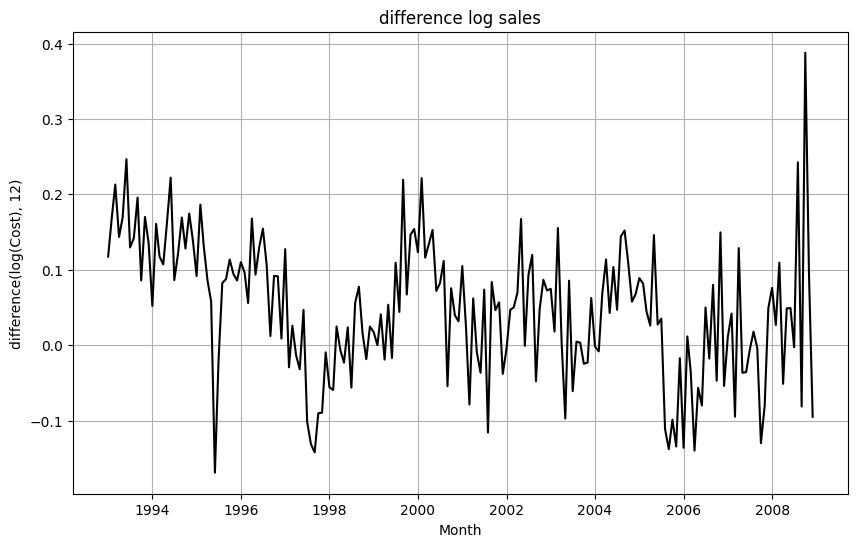

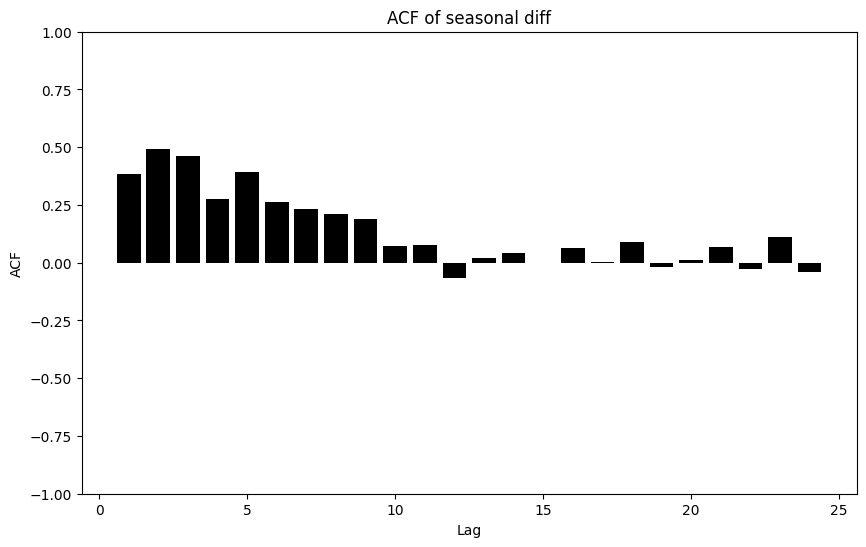

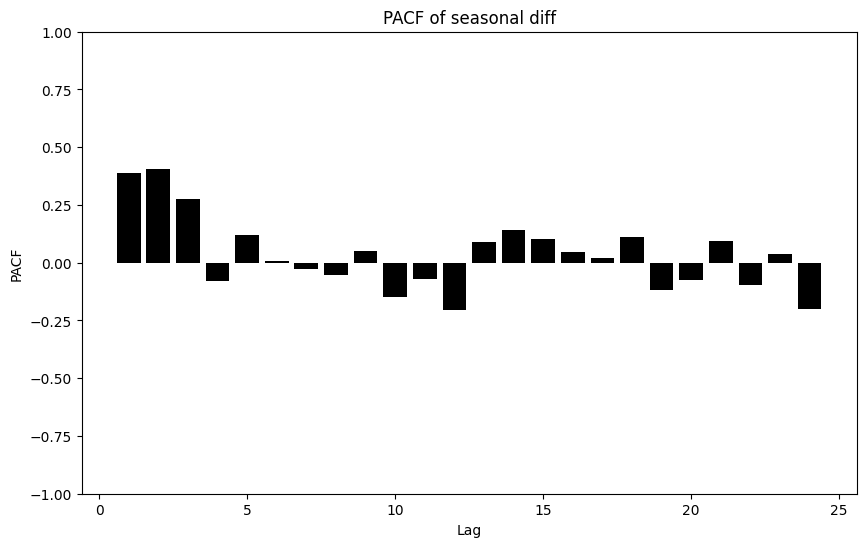

In [42]:
plot_series(h02, "Month", "Cost", "Corticosteroid drug sales")
plot_series(log_h02, "Month", "log(Cost)", "Log sales")
plot_series(diff12_h02, "Month", "difference(log(Cost), 12)", "difference log sales")
show_ACF(diff12_h02[12:], "ACF of seasonal diff", start=1, nlags=24)
show_PACF(diff12_h02[12:], "PACF of seasonal diff", start=1, nlags=24)

### ARIMA 모델 피팅

In [43]:
h02_arima = ARIMA(h02, order=(3,0,0), seasonal_order=(2,1,0,12))
h02_fit = h02_arima.fit()
print(h02_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  204
Model:             ARIMA(3, 0, 0)x(2, 1, 0, 12)   Log Likelihood                 287.764
Date:                          Fri, 07 Jun 2024   AIC                           -563.527
Time:                                  18:17:31   BIC                           -543.982
Sample:                              01-01-1992   HQIC                          -555.611
                                   - 12-01-2008                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0985      0.068      1.449      0.147      -0.035       0.232
ar.L2          0.3980      0.053      7.561      0.

### 잔차 시각화

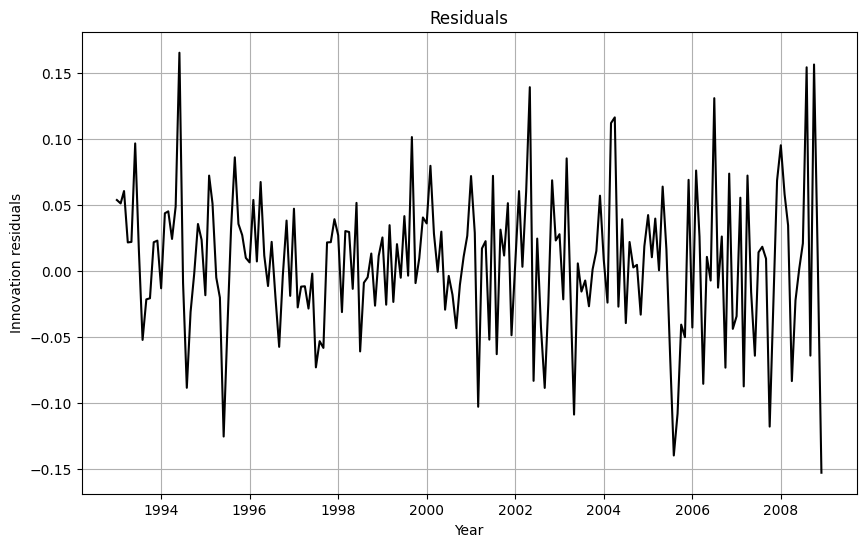

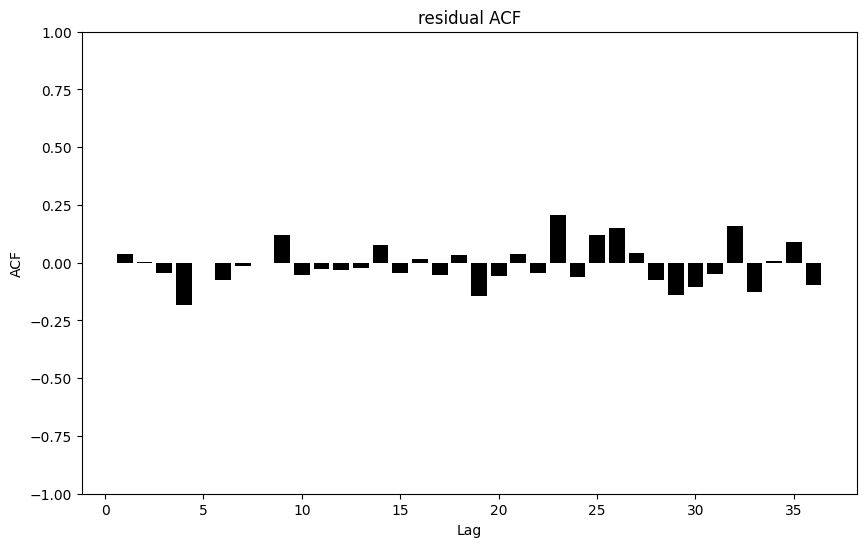

In [44]:
plot_series(h02_fit.resid[12:], "Year", "Innovation residuals", "Residuals")
show_ACF(h02_fit.resid[12:], "residual ACF", start = 1, nlags=36)

### ARIMA 모델 피팅 2

In [45]:
h02_arima2 = ARIMA(h02, order=(2,1,0), seasonal_order=(0,1,1,12))
h02_fit2 = h02_arima2.fit()
print(h02_fit2.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  204
Model:             ARIMA(2, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 284.000
Date:                            Fri, 07 Jun 2024   AIC                           -560.000
Time:                                    18:17:31   BIC                           -546.991
Sample:                                01-01-1992   HQIC                          -554.731
                                     - 12-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8430      0.064    -13.261      0.000      -0.968      -0.718
ar.L2         -0.3959      0.058   

### 잔차 시각화

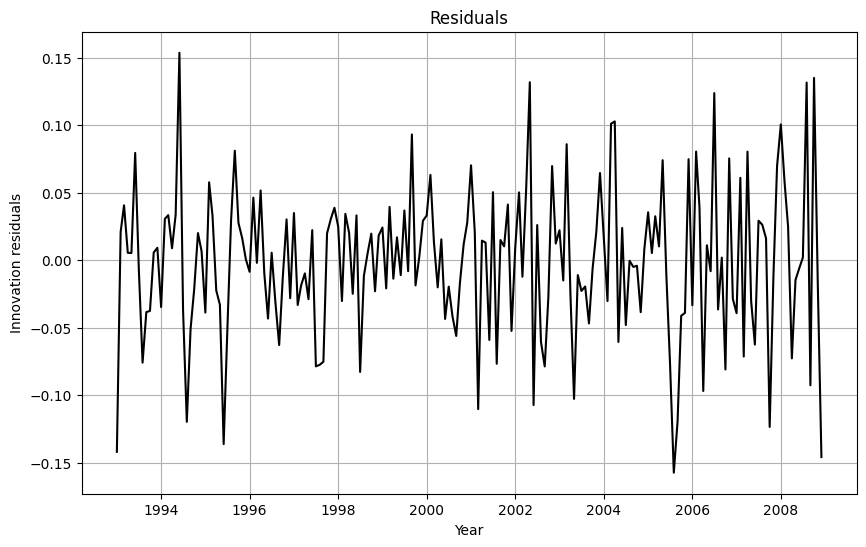

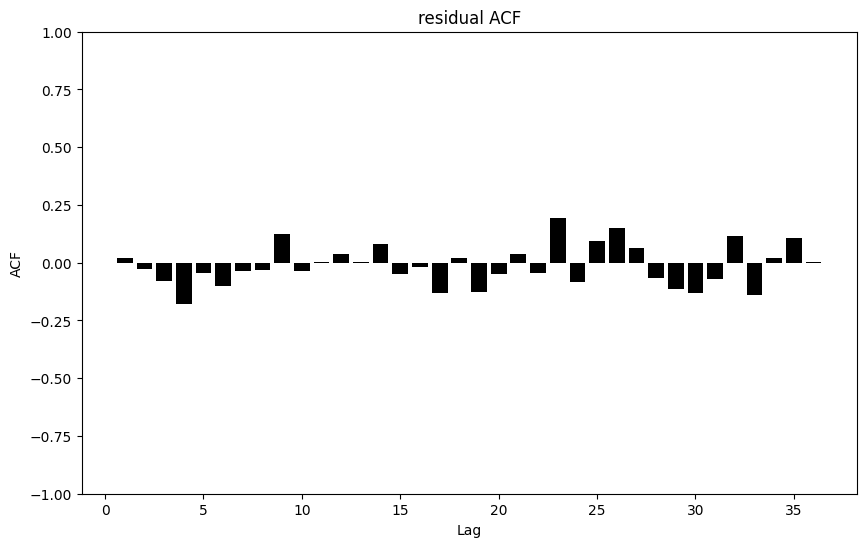

In [46]:
plot_series(h02_fit2.resid[12:], "Year", "Innovation residuals", "Residuals")
show_ACF(h02_fit2.resid[12:], "residual ACF", start = 1, nlags=36)

### ARIMA 모델 피팅 3

In [47]:
h02_arima3 = ARIMA(h02, order=(2,1,3), seasonal_order=(0,1,1,12))
h02_fit3 = h02_arima3.fit()
print(h02_fit3.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  204
Model:             ARIMA(2, 1, 3)x(0, 1, [1], 12)   Log Likelihood                 286.314
Date:                            Fri, 07 Jun 2024   AIC                           -558.629
Time:                                    18:17:33   BIC                           -535.863
Sample:                                01-01-1992   HQIC                          -549.408
                                     - 12-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2353      0.210     -5.889      0.000      -1.646      -0.824
ar.L2         -0.5680      0.222   

### 잔차 시각화

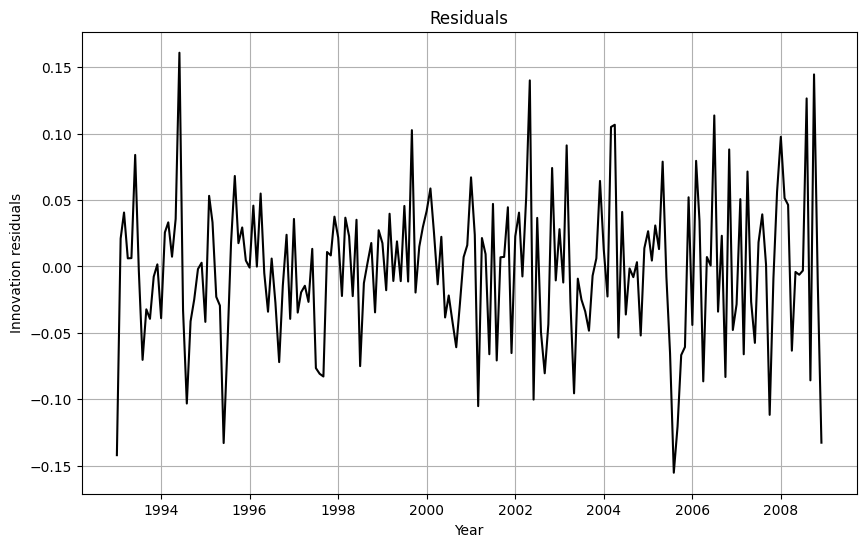

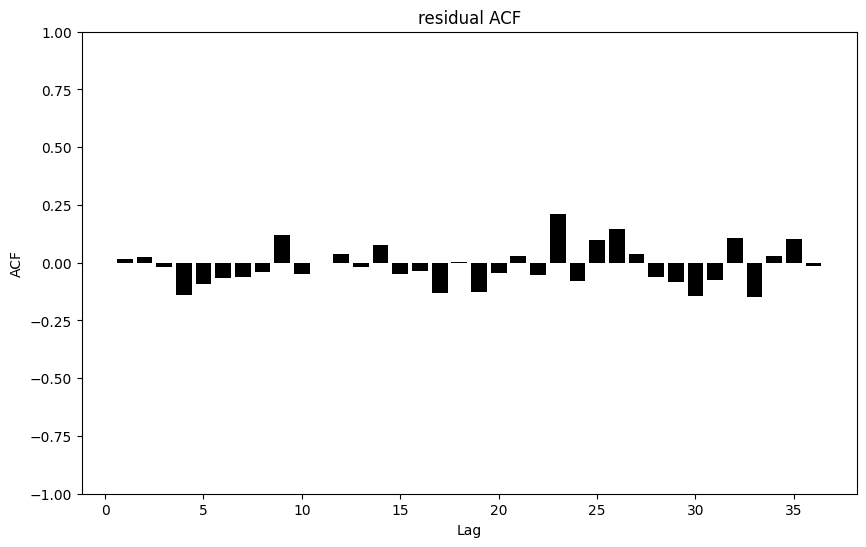

In [48]:
plot_series(h02_fit3.resid[12:], "Year", "Innovation residuals", "Residuals")
show_ACF(h02_fit3.resid[12:], "residual ACF", start = 1, nlags=36)

### 최종 ARIMA 모델 피팅

In [49]:
h02_arima_fin = ARIMA(h02, order=(3,0,1), seasonal_order=(0,1,2,12))
h02_fit_fin = h02_arima_fin.fit()

### 예측

In [50]:
forecast = h02_fit_fin.get_forecast(24).predicted_mean
ci = h02_fit_fin.get_forecast(24)
lower_ci80 = ci.conf_int(alpha=0.2).iloc[:,0]
upper_ci80 = ci.conf_int(alpha=0.2).iloc[:,1]
lower_ci95 = ci.conf_int(alpha=0.05).iloc[:,0]
upper_ci95 = ci.conf_int(alpha=0.05).iloc[:,1]

### 예측 시각화

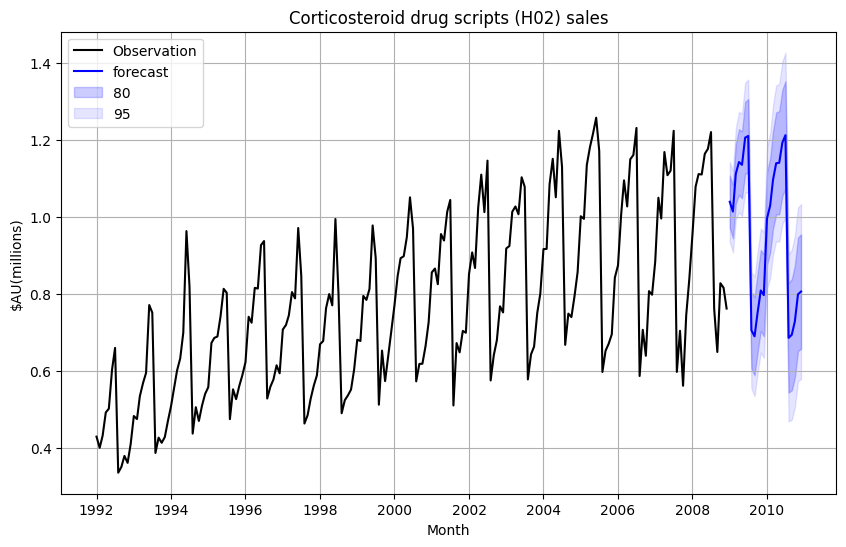

In [51]:
plt.figure(figsize=(10, 6))
plt.plot(h02, label='Observation', color='black')
plt.plot(forecast, label='forecast', color='b')
plt.fill_between(forecast.index, lower_ci80, upper_ci80, label='80', color='b', alpha=.2)
plt.fill_between(forecast.index, lower_ci95, upper_ci95, label='95', color='b', alpha=.1)
plt.xlabel('Month')
plt.ylabel('$AU(millions)')
plt.title("Corticosteroid drug scripts (H02) sales")
plt.grid(True)
plt.legend()
plt.show()

# 3.2.8 예측

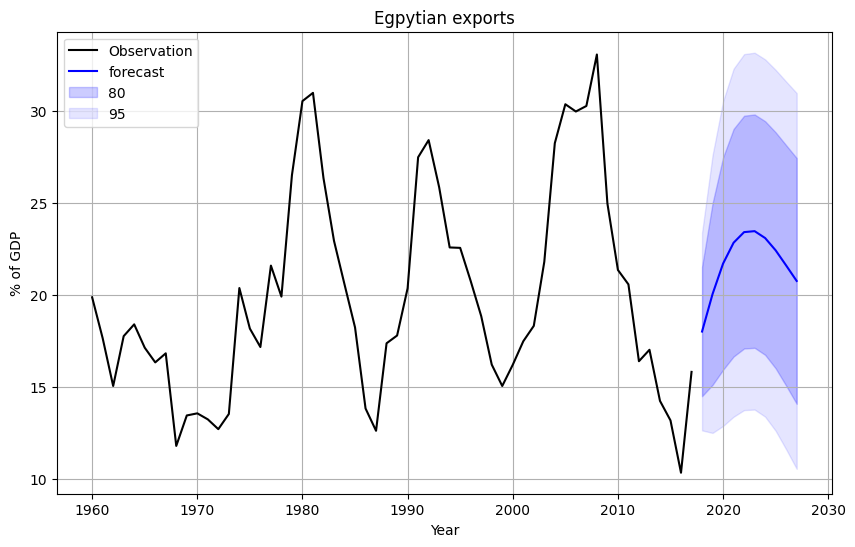

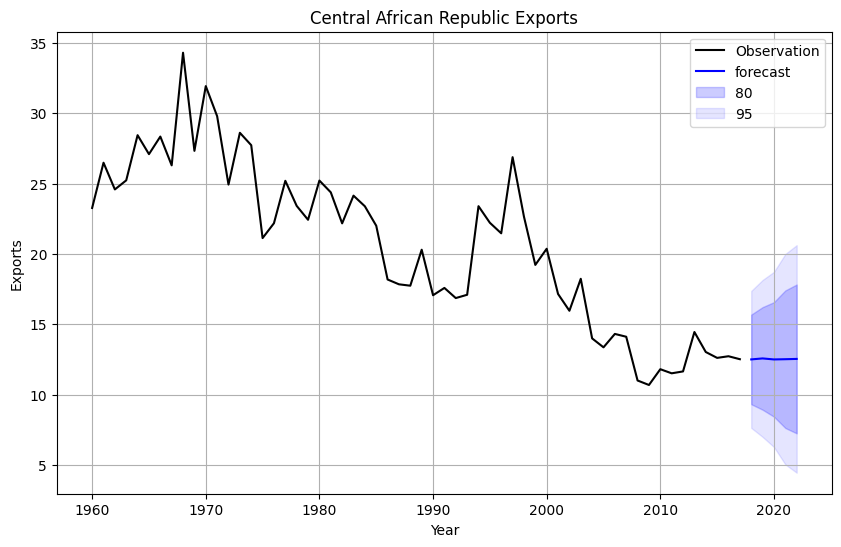

In [52]:
def show_forecast(series, fitted, horizon, x, y, title):
    forecast = fitted.get_forecast(horizon).predicted_mean
    ci = fitted.get_forecast(horizon)
    lower_ci80 = ci.conf_int(alpha=0.2).iloc[:,0]
    upper_ci80 = ci.conf_int(alpha=0.2).iloc[:,1]
    lower_ci95 = ci.conf_int(alpha=0.05).iloc[:,0]
    upper_ci95 = ci.conf_int(alpha=0.05).iloc[:,1]

    plt.figure(figsize=(10, 6))
    plt.plot(series, label='Observation', color='black')
    plt.plot(forecast, label='forecast', color='b')
    plt.fill_between(forecast.index, lower_ci80, upper_ci80, label='80', color='b', alpha=.2)
    plt.fill_between(forecast.index, lower_ci95, upper_ci95, label='95', color='b', alpha=.1)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

show_forecast(egypt_series, egypt_res, 10, "Year", "% of GDP", "Egpytian exports")

caf_model = ARIMA(caf_series, order=(3,1,0))
caf_res=caf_model.fit()
show_forecast(caf_series, caf_res, 5, "Year", "Exports", "Central African Republic Exports")

# 3.2.9 ARIMA vs ETS

## 예시

### 데이터

In [53]:
aus_pop = global_economy[global_economy["Code"] == 'AUS']
pop_series = pd.Series(list(aus_pop['Population']), aus_pop['Year'])

### ETS 피팅

In [54]:
fit = ETSModel(pop_series, trend='add').fit()
forecast = fit.forecast(5)
ci = fit.get_prediction(start = forecast.index[0], end = forecast.index[-1])
lower_ci80 = ci.pred_int(alpha=0.2).iloc[:,0]
upper_ci80 = ci.pred_int(alpha=0.2).iloc[:,1]
lower_ci95 = ci.pred_int(alpha=0.05).iloc[:,0]
upper_ci95 = ci.pred_int(alpha=0.05).iloc[:,1]

### 시각화

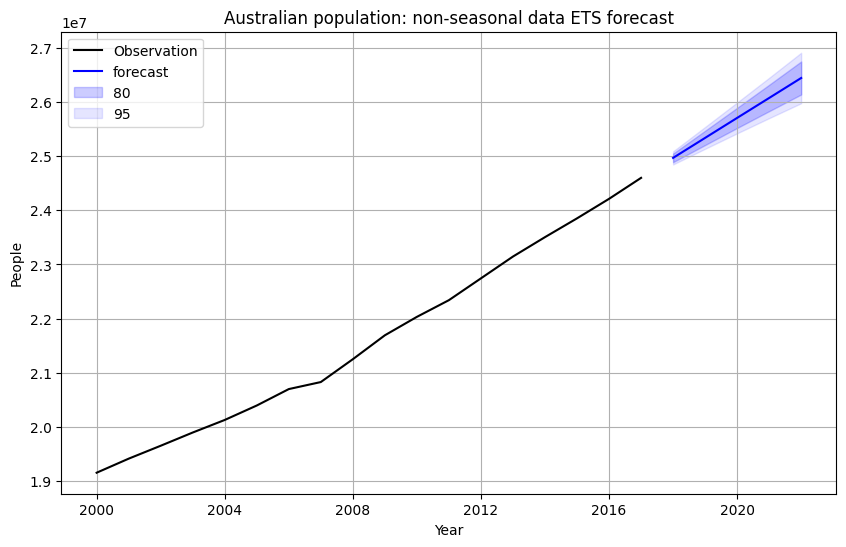

In [55]:
plt.figure(figsize=(10, 6))
plt.plot(pop_series[40:], label='Observation', color='black')
plt.plot(forecast, label='forecast', color='b')
plt.fill_between(forecast.index, lower_ci80, upper_ci80, label='80', color='b', alpha=.2)
plt.fill_between(forecast.index, lower_ci95, upper_ci95, label='95', color='b', alpha=.1)
plt.xlabel('Year')
plt.ylabel('People')
plt.title('Australian population: non-seasonal data ETS forecast')
plt.grid(True)
plt.legend()
plt.show()

## 예시

### 데이터 전처리

In [56]:
aus_prod = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/Econometrics/main/dataset/Ch.2/aus_production.csv')
aus_prod['y'] = aus_prod['Cement']
aus_prod['ds'] = pd.date_range(start='2/3/1956',periods=218, freq='3MS')
aus_prod = aus_prod[['y', 'ds']]
aus_prod = aus_prod[aus_prod['ds']>='1988-01-01']
df = aus_prod[aus_prod['ds']<='2007-12-31']
aus_series = pd.Series(list(df['y']), df['ds'])

### ARIMA 피팅

In [57]:
cem_ARIMA = ARIMA(aus_series, order=(1,0,1), seasonal_order=(2,1,1,4)) 
cem_ARIMA_fit = cem_ARIMA.fit()
print(cem_ARIMA_fit.summary())

                                    SARIMAX Results                                    
Dep. Variable:                               y   No. Observations:                   80
Model:             ARIMA(1, 0, 1)x(2, 1, 1, 4)   Log Likelihood                -464.849
Date:                         Fri, 07 Jun 2024   AIC                            941.697
Time:                                 18:17:36   BIC                            955.682
Sample:                             03-01-1988   HQIC                           947.286
                                  - 12-01-2007                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9998      0.031     32.614      0.000       0.940       1.060
ma.L1         -0.2995      0.114     -2.627      0.009     

### 시각화

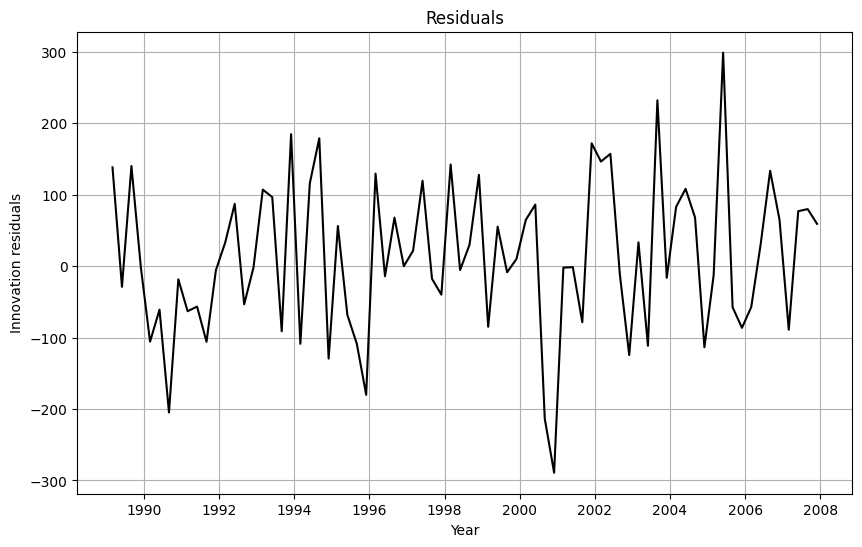

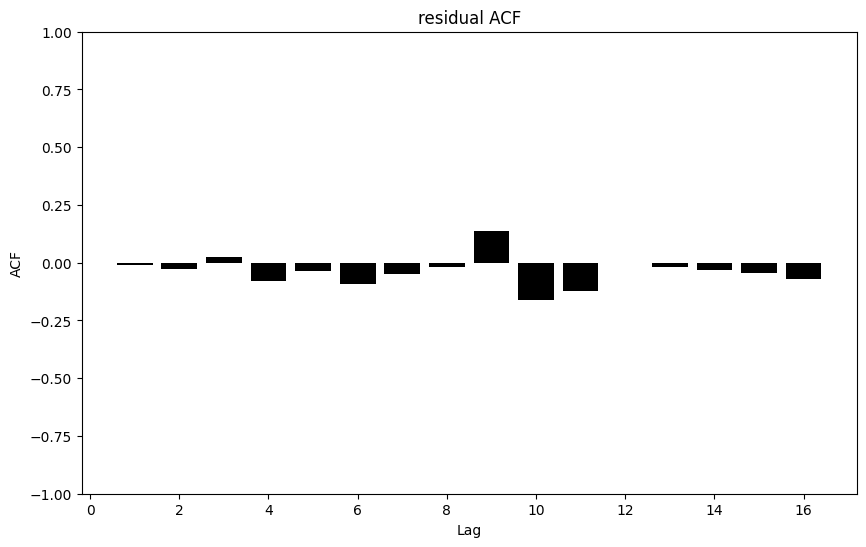

In [58]:
plot_series(cem_ARIMA_fit.resid[4:], "Year", "Innovation residuals", "Residuals")
show_ACF(cem_ARIMA_fit.resid[4:], "residual ACF", start = 1, nlags=16)

### ETS 피팅

In [59]:
cem_ETS_fit = ETSModel(aus_series, error='mul', trend=None, seasonal='mul').fit()
print(cem_ETS_fit.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                   80
Model:                       ETS(MNM)   Log Likelihood                -488.693
Date:                Fri, 07 Jun 2024   AIC                            993.386
Time:                        18:17:37   BIC                           1012.442
Sample:                    03-01-1988   HQIC                          1001.026
                         - 12-01-2007   Scale                            0.004
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.7419      0.099      7.521      0.000       0.549       0.935
smoothing_seasonal  2.581e-05        nan        nan        nan         nan         nan
initial_level       

### 시각화

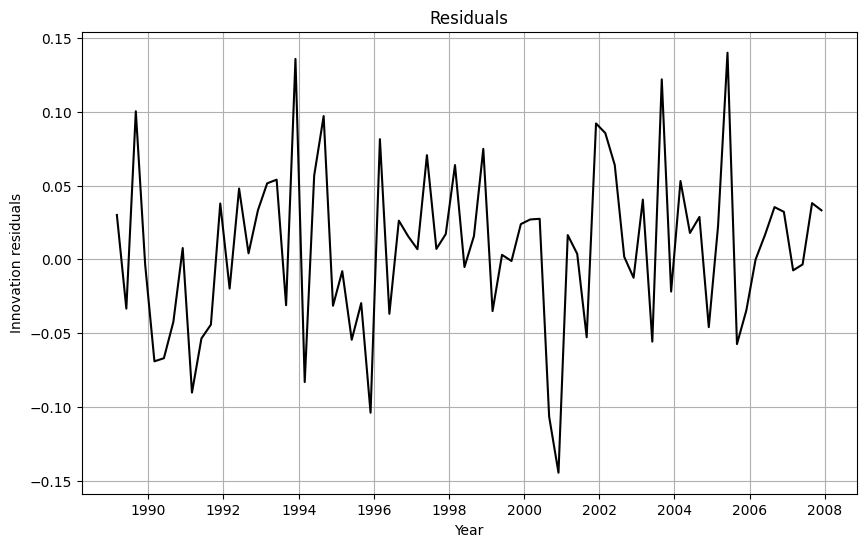

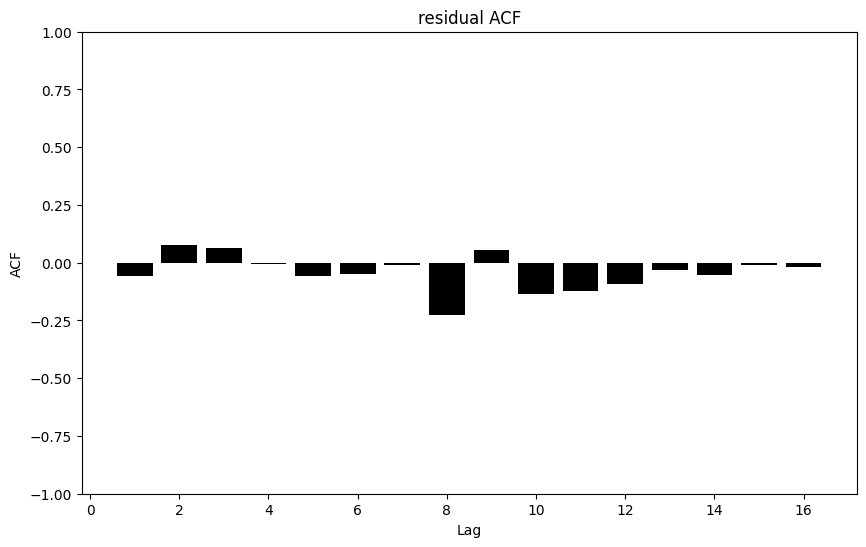

In [60]:
plot_series(cem_ETS_fit.resid[4:], "Year", "Innovation residuals", "Residuals")
show_ACF(cem_ETS_fit.resid[4:], "residual ACF", start = 1, nlags=16)

### 예측시각화

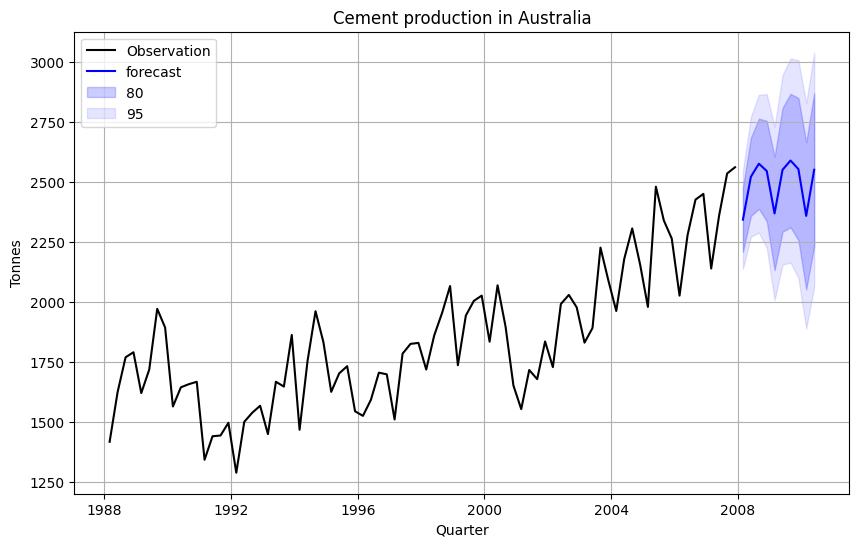

In [61]:
show_forecast(aus_series, cem_ARIMA_fit, 10, "Quarter", "Tonnes", "Cement production in Australia")

### 평가

In [62]:
ans = aus_prod[aus_prod['ds'] <= '2010-07-01']
ans = ans[ans['ds'] >= '2008-01-01']
ARIMA_for = cem_ARIMA_fit.get_forecast(10).predicted_mean
ETS_for = cem_ETS_fit.forecast(10)

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

print(f"ARIMA) MSE: {mean_squared_error(ans['y'], ARIMA_for.values)} MAE: {mean_absolute_error(ans['y'], ARIMA_for.values)} MAPE: {mean_absolute_percentage_error(ans['y'], ARIMA_for.values)}")
print(f"ETS) MSE: {mean_squared_error(ans['y'], ETS_for.values)} MAE: {mean_absolute_error(ans['y'], ETS_for.values)} MAPE: {mean_absolute_percentage_error(ans['y'], ETS_for.values)}")

ARIMA) MSE: 75590.44520383912 MAE: 235.46775062736742 MAPE: 0.11017910983071795
ETS) MSE: 49627.9036946374 MAE: 191.98448008217397 MAPE: 0.08903137556888266
